# README

This version just does a quick and dirty test of all of the data. Allows me to test out different permutations of the dataset very quickly (ideally anyway). 

# 1 - Prepping data and Importing Functions

## 1.1 - Import Packages

In [36]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For missing analysis
import missingno as msno

# For stratified Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

# For label encoding
from sklearn.preprocessing import LabelEncoder

# For imputing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# For Encoding and Preprocessing
from sklearn import preprocessing
import category_encoders as ce

# For feature selection
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# For Outlier Detection
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Nested CV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# For Evaluation
from sklearn import metrics
from imblearn.metrics import geometric_mean_score, specificity_score
from sklearn.metrics import roc_curve, auc

# For Model Interpretability
import shap

# For recording results
from secret import api_
import neptune


# For correlation analysis
import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

pd.options.mode.copy_on_write = True
pd.set_option('display.max_rows', 60)

## 1.2 - Selecting variables, subset of data

In [33]:
df1=pd.read_csv('../ClassIIIObesityStudy data export.csv')
df2=pd.read_csv('../Data_CSV/Database obesity and delivery.csv')

# Merge to get age
df = pd.merge(df1,df2, how='inner', on='record_id', suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)

# We want specifically nulliparous women
#df = df[(df['parity_t']== 0 ) & (df['parity_p']==0)]

# Also want people that either had oxy induction or ripening of some type
df = df[(df['oxy_indc']== 1 ) | (df['use_ripen'] != 0)]

# Reducing mode of delivery to just cesarean vs. non-cesarean
def group(x):
    if x==1.0 or x==2.0 or x==3.0 :
        return 0
    else :
        return 1  

df['mode_del']= df['mode_del'].apply(group)


# Select desired variables -------------------------
desiredVar = ['wt', 'ht', 'age', 'pre_bmi', 'race', 'payor_status', 'parity_t', 'parity_p','use_ripen','spcy_ripen',
              'on_med','gbs_status', 'gestage_delivery', 'bmi_delivery','preeclampsia', 'preec_severe', 
              'diab_mell', 'diab_class', 'cervex_dialation', 'cervex_efface','cervex_station',
              'ante_hosp', 'ante_hosp_noadm', 'oxy_augumtn', 'oxy_maxdose', 'chro_hyper', 'gest_hyper',
              'neo_gen','mode_del']

df = df[desiredVar]


cesPop = df[df['mode_del'] == 1]
nonCesPop = df[df['mode_del'] == 0]

In [314]:
cesPop['use_ripen'].value_counts(normalize=True)*100

use_ripen
1.0    75.897436
0.0    24.102564
Name: proportion, dtype: float64

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!


## 1.3 - Collapsing Features and Feature Engineering

In [34]:
#df["Nulliparous"] = 0
#df["Nulliparous"] = np.where( (df["parity_p"] == 0.0) & (df["parity_t"] == 0.0), 1, df["Nulliparous"])
df.drop(labels=["parity_p","parity_t"], axis=1, inplace=True)



# Collapsing Diabetes categories
df["Diabetes"] = np.NaN
df["Diabetes"] = np.where(df["diab_mell"] == 0.0, "No Diabetes", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 1.0, "Diabetes (Type 1)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 2.0, "Diabetes (Type 2)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 3.0, "Diabetes (A1)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 4.0, "Diabetes (A2)", df["Diabetes"])
df.drop(labels=["diab_class","diab_mell"], axis=1, inplace=True)

"""
# Collapsing Diabetes categories
df["Diabetes"] = None
df["Diabetes"] = np.where(df["diab_mell"] == 0.0, 0, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 1.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 2.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 3.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 4.0, 1, df["Diabetes"])
df.drop(labels=["diab_class","diab_mell"], axis=1, inplace=True)


# Collapsing Preeclampsia categories
# In cases where preeclampsia is 0.0, preeclampsia severe is a missing value. 
df["Preeclampsia_Status"] = np.NaN
df["Preeclampsia_Status"] = np.where(df["preeclampsia"] == 0.0, 0, df["Preeclampsia_Status"])
df["Preeclampsia_Status"] = np.where(df["preec_severe"] == 0.0, 1, df["Preeclampsia_Status"])
df["Preeclampsia_Status"] = np.where(df["preec_severe"] == 1.0, 1, df["Preeclampsia_Status"])
df.drop(labels=["preeclampsia","preec_severe"], axis=1, inplace=True)
"""


# If they don't have hypertension, they're not being medicated for it
df["on_med"] = np.where((df["chro_hyper"] == 0.0) & (df["gest_hyper"] == 0.0), 0, df["on_med"])


# If they don't have preeclampsia, they don't have severe preeclampsia
df["preec_severe"] = np.where(df["preeclampsia"] == 0.0, 0, df["preec_severe"])
# Same for ripening
df["spcy_ripen"] = np.where(df["use_ripen"] == 0.0, 0, df["spcy_ripen"])


# Same for maxdose
df["oxy_maxdose"] = np.where(df["oxy_augumtn"] == 0.0, 0, df["oxy_maxdose"])
#df.drop(labels=["use_ripen"], axis=1, inplace=True)

# Doing this the hard way to make sure I'm not accidentally overwriting missing
df["AntepartumHospAdmissions"] = np.NaN
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp"] == 0.0, 0, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 1.0, 1, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 2.0, 2, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 3.0, 3, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 4.0, 4, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 5.0, 5, df["AntepartumHospAdmissions"])
df.drop(labels=["ante_hosp","ante_hosp_noadm"], axis=1, inplace=True)


# Making cervex station ordinal
df["cervex_station"] = np.where(df["cervex_station"] == -5.0, 0, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -4.0, 1, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -3.0, 2, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -2.0, 3, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -1.0, 4, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == 0.0, 5, df["cervex_station"])



# Collapsing Hypertension categories
df["Hypertension"] = 0
df["Hypertension"] = np.where(df["chro_hyper"] == 1.0, 1, df["Hypertension"])
df["Hypertension"] = np.where(df["gest_hyper"] == 1.0, 1, df["Hypertension"])
df.drop(labels=["chro_hyper","gest_hyper"], axis=1, inplace=True)


# Getting the weight change variable
df['weightDelivery'] = (df['bmi_delivery']/703)*(df['ht']**2)
df['weightChange'] = df['weightDelivery'] - df['wt']
df.drop(labels=["weightDelivery"], axis=1, inplace=True)  

# BMI Variables
#df['bmiChange'] = df['pre_bmi'] - df['bmi_delivery']
df.drop(labels=["pre_bmi","bmi_delivery"], axis=1, inplace=True)  

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 0,
    2.0: 1,
}

# Use map() to create a new column with categories
df['neo_gen'] = df['neo_gen'].map(value_to_category)



"""
# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Race (White)',
    2.0: 'Race (Black)',
    3.0: 'Race (Hispanic)',
    4.0: 'Race (Asian)',
    5.0: 'Race (Native)',
    6.0: 'Unknown Race',
    7.0: 'Unknown Race'
}

# Use map() to create a new column with categories
df['race'] = df['race'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Self Pay Insurance',
    2.0: 'Government Insurance',
    3.0: 'Commercial Insurance',
}

# Use map() to create a new column with categories
df['payor_status'] = df['payor_status'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'GBS (Positive)',
    2.0: 'GBS (Negative)',
    3.0: 'GBS (Unknown)',
}

# Use map() to create a new column with categories
df['gbs_status'] = df['gbs_status'].map(value_to_category)

"""

df.replace('#NUM!', np.nan, inplace=True)


#df.drop(labels=["spcy_ripen"], axis=1, inplace=True)
df.drop(labels=["use_ripen"], axis=1, inplace=True)

In [22]:
df.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'spcy_ripen', 'on_med',
       'gbs_status', 'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Diabetes', 'Preeclampsia_Status', 'AntepartumHospAdmissions',
       'Hypertension', 'weightChange'],
      dtype='object')

In [23]:
df.shape

(265, 21)

In [23]:
df['Diabetes'].value_counts()

Diabetes
0    211
1     54
Name: count, dtype: int64

## 1.4 Analysis

In [317]:
df["Nulliparous"] = 0
df["Nulliparous"] = np.where( (df["parity_p"] == 0.0) & (df["parity_t"] == 0.0), 1, df["Nulliparous"])
df.drop(labels=["parity_p","parity_t"], axis=1, inplace=True)


# Collapsing Diabetes categories
df["Diabetes"] = np.NaN
df["Diabetes"] = np.where(df["diab_mell"] == 0.0, "No Diabetes", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 1.0, "Diabetes (Type 1)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 2.0, "Diabetes (Type 2)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 3.0, "Diabetes (A1)", df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 4.0, "Diabetes (A2)", df["Diabetes"])
df.drop(labels=["diab_class","diab_mell"], axis=1, inplace=True)

"""
# Collapsing Diabetes categories
df["Diabetes"] = None
df["Diabetes"] = np.where(df["diab_mell"] == 0.0, 0, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 1.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 2.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 3.0, 1, df["Diabetes"])
df["Diabetes"] = np.where(df["diab_class"] == 4.0, 1, df["Diabetes"])
df.drop(labels=["diab_class","diab_mell"], axis=1, inplace=True)


# Collapsing Preeclampsia categories
# In cases where preeclampsia is 0.0, preeclampsia severe is a missing value. 
df["Preeclampsia_Status"] = np.NaN
df["Preeclampsia_Status"] = np.where(df["preeclampsia"] == 0.0, 0, df["Preeclampsia_Status"])
df["Preeclampsia_Status"] = np.where(df["preec_severe"] == 0.0, 1, df["Preeclampsia_Status"])
df["Preeclampsia_Status"] = np.where(df["preec_severe"] == 1.0, 1, df["Preeclampsia_Status"])
df.drop(labels=["preeclampsia","preec_severe"], axis=1, inplace=True)
"""


# If they don't have hypertension, they're not being medicated for it
df["on_med"] = np.where((df["chro_hyper"] == 0.0) & (df["gest_hyper"] == 0.0), 0, df["on_med"])


# If they don't have preeclampsia, they don't have severe preeclampsia
df["preec_severe"] = np.where(df["preeclampsia"] == 0.0, 0, df["preec_severe"])
# Same for ripening
df["spcy_ripen"] = np.where(df["use_ripen"] == 0.0, 0, df["spcy_ripen"])


# Same for maxdose
df["oxy_maxdose"] = np.where(df["oxy_augumtn"] == 0.0, 0, df["oxy_maxdose"])
df.drop(labels=["use_ripen"], axis=1, inplace=True)

# Doing this the hard way to make sure I'm not accidentally overwriting missing
df["AntepartumHospAdmissions"] = np.NaN
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp"] == 0.0, 0, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 1.0, 1, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 2.0, 2, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 3.0, 3, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 4.0, 4, df["AntepartumHospAdmissions"])
df["AntepartumHospAdmissions"] = np.where(df["ante_hosp_noadm"] == 5.0, 5, df["AntepartumHospAdmissions"])
df.drop(labels=["ante_hosp","ante_hosp_noadm"], axis=1, inplace=True)

"""
# Making cervex station ordinal
df["cervex_station"] = np.where(df["cervex_station"] == -5.0, 0, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -4.0, 1, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -3.0, 2, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -2.0, 3, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == -1.0, 4, df["cervex_station"])
df["cervex_station"] = np.where(df["cervex_station"] == 0.0, 5, df["cervex_station"])
"""

"""
# Collapsing Hypertension categories
df["Hypertension"] = 0
df["Hypertension"] = np.where(df["chro_hyper"] == 1.0, 1, df["Hypertension"])
df["Hypertension"] = np.where(df["gest_hyper"] == 1.0, 1, df["Hypertension"])
df.drop(labels=["chro_hyper","gest_hyper"], axis=1, inplace=True)
"""

# Getting the weight change variable
df['weightDelivery'] = (df['bmi_delivery']/703)*(df['ht']**2)
df['weightChange'] = df['weightDelivery'] - df['wt']
#df.drop(labels=["weightDelivery"], axis=1, inplace=True)  

# BMI Variables
#df['bmiChange'] = df['pre_bmi'] - df['bmi_delivery']
df.drop(labels=["pre_bmi","bmi_delivery"], axis=1, inplace=True)  

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 0,
    2.0: 1,
}

# Use map() to create a new column with categories
#df['neo_gen'] = df['neo_gen'].map(value_to_category)



"""
# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Race (White)',
    2.0: 'Race (Black)',
    3.0: 'Race (Hispanic)',
    4.0: 'Race (Asian)',
    5.0: 'Race (Native)',
    6.0: 'Unknown Race',
    7.0: 'Unknown Race'
}

# Use map() to create a new column with categories
df['race'] = df['race'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Self Pay Insurance',
    2.0: 'Government Insurance',
    3.0: 'Commercial Insurance',
}

# Use map() to create a new column with categories
df['payor_status'] = df['payor_status'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'GBS (Positive)',
    2.0: 'GBS (Negative)',
    3.0: 'GBS (Unknown)',
}

# Use map() to create a new column with categories
df['gbs_status'] = df['gbs_status'].map(value_to_category)

"""

df.replace('#NUM!', np.nan, inplace=True)


#df.drop(labels=["spcy_ripen"], axis=1, inplace=True)

In [ ]:
df['preec_severe'].

In [231]:
df.columns

Index(['wt', 'ht', 'age', 'pre_bmi', 'race', 'payor_status', 'spcy_ripen',
       'on_med', 'gbs_status', 'gestage_delivery', 'bmi_delivery',
       'preeclampsia', 'preec_severe', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Diabetes', 'AntepartumHospAdmissions', 'weightDelivery',
       'weightChange', 'Hypertension', 'weightAtFirstVisit'],
      dtype='object')

In [233]:
df['cervex_efface'].describe()

count    245.000000
mean      39.061224
std       27.852369
min        0.000000
25%       10.000000
50%       50.000000
75%       60.000000
max      100.000000
Name: cervex_efface, dtype: float64

In [228]:
df['weightAtFirstVisit'] =(df['pre_bmi']*(df['ht']**2))/703

In [229]:
df[['weightAtFirstVisit', 'wt']]

,weightAtFirstVisit,wt
2,253.0,253.0
10,378.0,378.0
20,213.0,213.0
23,463.0,463.0
24,346.0,346.0
...,...,...
1254,235.0,235.0
1262,217.0,217.0
1264,235.0,235.0
1268,171.0,171.0


In [289]:
# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Misoprostol',
    2.0: 'Foley Bulb',
    3.0: 'Miso and Foley',
    4.0: 'Cervidil', 
    5.0: 'Other'
}

# Use map() to create a new column with categories
#df['spcy_ripen'] = df['spcy_ripen'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Self',
    2.0: 'Government',
    3.0: 'Commercial',
}

# Use map() to create a new column with categories
df['payor_status'] = df['payor_status'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'Race (White)',
    2.0: 'Race (Black)',
    3.0: 'Race (Hispanic)',
    4.0: 'Race (Asian)',
    5.0: 'Race (Native)',
    6.0: 'Unknown Race',
    7.0: 'Unknown Race'
}


# Use map() to create a new column with categories
df['race'] = df['race'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: 'GBS (Positive)',
    2.0: 'GBS (Negative)',
    3.0: 'GBS (Unknown)',
}

# Use map() to create a new column with categories
df['gbs_status'] = df['gbs_status'].map(value_to_category)

# Define a dictionary to map values to categories
value_to_category = {
    1.0: "Female",
    2.0: "Male",
}

# Use map() to create a new column with categories
df['neo_gen'] = df['neo_gen'].map(value_to_category)


# Collapsing Hypertension categories
#df["Hypertension"] = 0
#df["Hypertension"] = np.where(df["chro_hyper"] == 1.0, "Chronic Hypertension", df["Hypertension"])
#df["Hypertension"] = np.where(df["gest_hyper"] == 1.0, "Gestational Hypertension", df["Hypertension"])
#df.drop(labels=["chro_hyper","gest_hyper"], axis=1, inplace=True)

cesPop = df[df['mode_del'] == 1]
nonCesPop = df[df['mode_del'] == 0]

In [290]:
df.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'on_med', 'gbs_status',
       'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Diabetes', 'Preeclampsia_Status', 'AntepartumHospAdmissions',
       'Hypertension', 'weightChange'],
      dtype='object')

In [297]:
df['use_ripen'].value_counts()

KeyError: 'use_ripen'

In [243]:
df['preec_severe'].value_counts(normalize=True)*100

preec_severe
0.0    87.924528
1.0    12.075472
Name: proportion, dtype: float64

In [161]:
df.shape

(920, 25)

In [244]:
cesPop['preec_severe'].value_counts(normalize=True)*100

preec_severe
0.0    87.837838
1.0    12.162162
Name: proportion, dtype: float64

In [246]:
cesPop['preec_severe'].value_counts()

preec_severe
0.0    130
1.0     18
Name: count, dtype: int64

In [248]:
nonCesPop['preec_severe'].value_counts(normalize=True)*100

preec_severe
0.0    88.034188
1.0    11.965812
Name: proportion, dtype: float64

In [247]:
nonCesPop['preec_severe'].value_counts()

preec_severe
0.0    103
1.0     14
Name: count, dtype: int64

In [141]:
df['Hypertension'].value_counts()

Hypertension
0                           135
Gestational Hypertension     66
Chronic Hypertension         64
Name: count, dtype: int64

In [142]:
df['Hypertension'].value_counts(normalize=True)*100

Hypertension
0                           50.943396
Gestational Hypertension    24.905660
Chronic Hypertension        24.150943
Name: proportion, dtype: float64

In [221]:
cesPop['oxy_maxdose'].describe()

count    127.000000
mean      15.118110
std       11.763958
min        0.000000
25%        4.000000
50%       16.000000
75%       22.000000
max       36.000000
Name: oxy_maxdose, dtype: float64

In [222]:
nonCesPop['oxy_maxdose'].describe()

count    116.000000
mean       9.887931
std       11.003376
min        0.000000
25%        0.000000
50%        6.500000
75%       18.000000
max       36.000000
Name: oxy_maxdose, dtype: float64

In [223]:
df['oxy_maxdose'].describe()

count    243.000000
mean      12.621399
std       11.680875
min        0.000000
25%        0.000000
50%       12.000000
75%       20.000000
max       36.000000
Name: oxy_maxdose, dtype: float64

In [225]:
df.shape

(265, 25)

In [ ]:
df.groupby(['mode_del'])['weightDelivery'].describe()

In [48]:
df['mode_del'].value_counts()

mode_del
1    148
0    117
Name: count, dtype: int64

In [47]:
df['race'].value_counts()

race
Race (White)       152
Race (Black)        47
Race (Hispanic)     44
Race (Native)       16
Unknown Race         5
Race (Asian)         1
Name: count, dtype: int64

In [469]:
df['race'].value_counts()/df.shape[0]*100

race
Race (White)       57.358491
Race (Black)       17.735849
Race (Hispanic)    16.603774
Race (Native)       6.037736
Unknown Race        1.886792
Race (Asian)        0.377358
Name: count, dtype: float64

In [470]:
df['race'].value_counts()

race
Race (White)       152
Race (Black)        47
Race (Hispanic)     44
Race (Native)       16
Unknown Race         5
Race (Asian)         1
Name: count, dtype: int64

In [472]:
df.groupby(['mode_del'])['race'].value_counts()

mode_del  race           
0         Race (White)       75
          Race (Hispanic)    19
          Race (Black)       16
          Race (Native)       3
          Unknown Race        3
          Race (Asian)        1
1         Race (White)       77
          Race (Black)       31
          Race (Hispanic)    25
          Race (Native)      13
          Unknown Race        2
Name: count, dtype: int64

In [473]:
df.groupby(['mode_del'])['race'].value_counts()/df.shape[0]*100

mode_del  race           
0         Race (White)       28.301887
          Race (Hispanic)     7.169811
          Race (Black)        6.037736
          Race (Native)       1.132075
          Unknown Race        1.132075
          Race (Asian)        0.377358
1         Race (White)       29.056604
          Race (Black)       11.698113
          Race (Hispanic)     9.433962
          Race (Native)       4.905660
          Unknown Race        0.754717
Name: count, dtype: float64

In [452]:
df.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'spcy_ripen', 'on_med',
       'gbs_status', 'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Nulliparous', 'Diabetes', 'Preeclampsia_Status',
       'AntepartumHospAdmissions', 'Hypertension', 'weightDelivery',
       'weightChange'],
      dtype='object')

In [357]:
#df.dropna(inplace=True)
df['age'] = df['age'].astype(int)

In [457]:
df.groupby(['mode_del'])['weightDelivery'].describe()

,count,mean,std,min,25%,50%,75%,max
mode_del,,,,,,,,
0,117.0,267.671562,34.350867,194.108108,242.802276,266.913514,287.827169,374.828307
1,148.0,279.018903,45.742128,207.968706,243.971337,270.347653,304.024751,479.052632


In [383]:
df['weightDelivery'].describe()

count    916.000000
mean     274.515472
std       44.757386
min      193.800853
25%      242.635206
50%      263.938549
75%      297.990754
max      558.286771
Name: weightDelivery, dtype: float64

In [248]:
df.isnull().sum()

wt                            3
ht                            3
age                           1
race                          3
payor_status                  3
spcy_ripen                  557
on_med                      164
gbs_status                    4
gestage_delivery              3
preeclampsia                  3
preec_severe                  3
cervex_dialation            295
cervex_efface               297
cervex_station              298
oxy_augumtn                 316
oxy_maxdose                 318
chro_hyper                    3
gest_hyper                    3
neo_gen                       6
mode_del                      0
Nulliparous                   0
Diabetes                      0
AntepartumHospAdmissions      4
weightDelivery                4
weightChange                  4
dtype: int64

In [76]:
df.isnull().sum() / (df.shape[0] / 100)

wt                           0.326087
ht                           0.326087
age                          0.108696
race                         0.326087
payor_status                 0.326087
spcy_ripen                  34.239130
on_med                       0.326087
gbs_status                   0.434783
gestage_delivery             0.326087
preeclampsia                 0.326087
preec_severe                 0.326087
cervex_dialation            32.065217
cervex_efface               32.282609
cervex_station              32.391304
oxy_augumtn                 34.347826
oxy_maxdose                 34.565217
chro_hyper                   0.326087
gest_hyper                   0.326087
neo_gen                      0.652174
mode_del                     0.000000
Nulliparous                  0.000000
Diabetes                     0.000000
AntepartumHospAdmissions     0.434783
weightDelivery               0.434783
weightChange                 0.434783
dtype: float64

In [251]:
df.columns

Index(['wt', 'ht', 'age', 'pre_bmi', 'race', 'payor_status', 'spcy_ripen',
       'on_med', 'gbs_status', 'gestage_delivery', 'bmi_delivery',
       'preeclampsia', 'preec_severe', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'chro_hyper',
       'gest_hyper', 'neo_gen', 'mode_del', 'Nulliparous', 'Diabetes',
       'AntepartumHospAdmissions', 'weightDelivery', 'weightChange'],
      dtype='object')

In [47]:
feature_display_names = {
    'wt': 'Weight at First Visit',
    'weightDelivery': 'Weight at Delivery',
    'weightChange': 'Weight Change',
    'ht': 'Height',
    'age': 'Age',
    'gestage_delivery': 'Gest. age at delivery',
    'on_med': 'On Medication (Hypertension)',
    'cervex_dialation': 'Cervix Dilation',
    'oxy_augumtn': 'Oxy Augmentation',
    'oxy_maxdose': 'Oxy Max Dose',
    'race': 'Race',
    'payor_status': 'Insurance Status',
    'gbs_status': 'GBS Status',
    'cervex_station': 'Cervix Station',
    'cervex_efface': 'Cervix Efface',
    'AntepartumHospAdmissions': 'Antepartum Hosp. Admission',
    'neo_gen': 'Neonatal Gender',
    'mode_del': 'Cesarean',
    'spcy_ripen': 'Ripening Method',
    "chro_hyper":"Chronic Hypertension",
    "gest_hyper": "Gestational Hypertension",
    "preeclampsia": "Preeclampsia",
    "preec_severe": "Preeclampsia (Severe)" 
    # Add more mappings as needed
}

missing = df.rename(columns=feature_display_names)
#missing.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)  
#missing.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)  

### Nulliparous Missingness

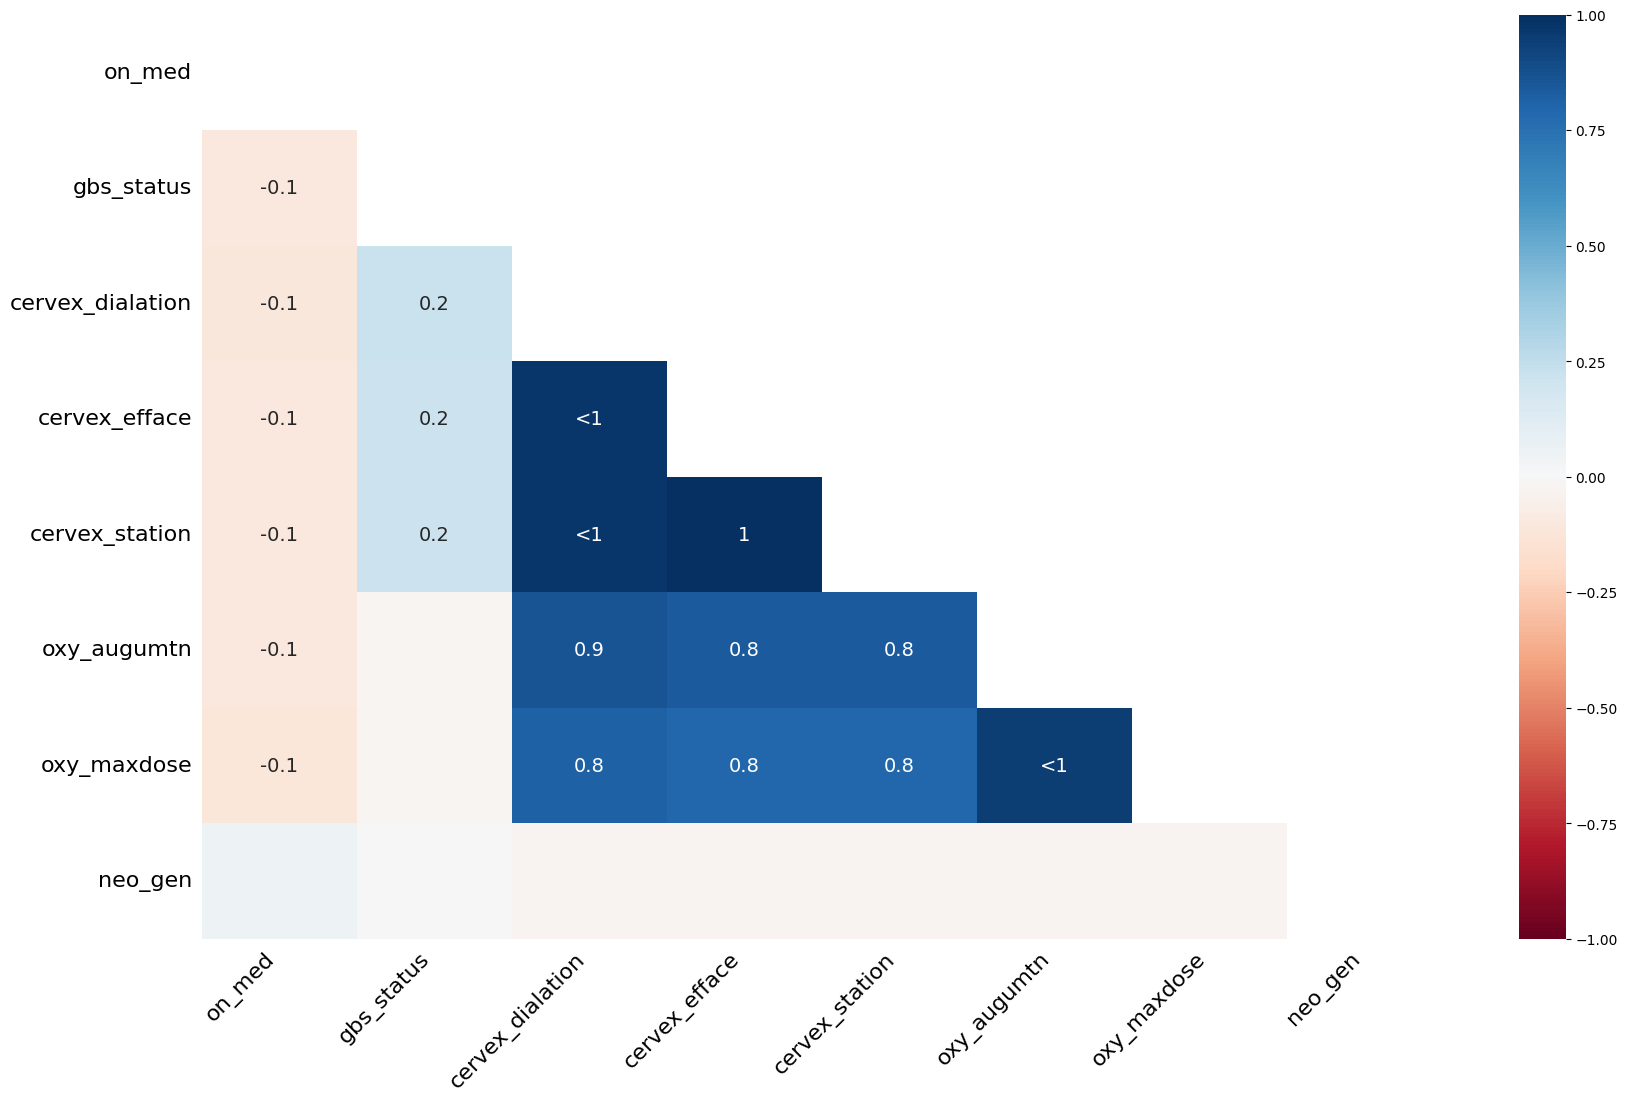

In [37]:
import missingno as msno

# I want to double check only the columns that have missing values
#nullCols = missing.columns[missing.isnull().any()]

fig = msno.heatmap(df)
fig_copy = fig.get_figure()
#fig_copy.savefig('../Images/Cesarean_missingno_multiparous.png', dpi=400, bbox_inches = "tight")

<Axes: >

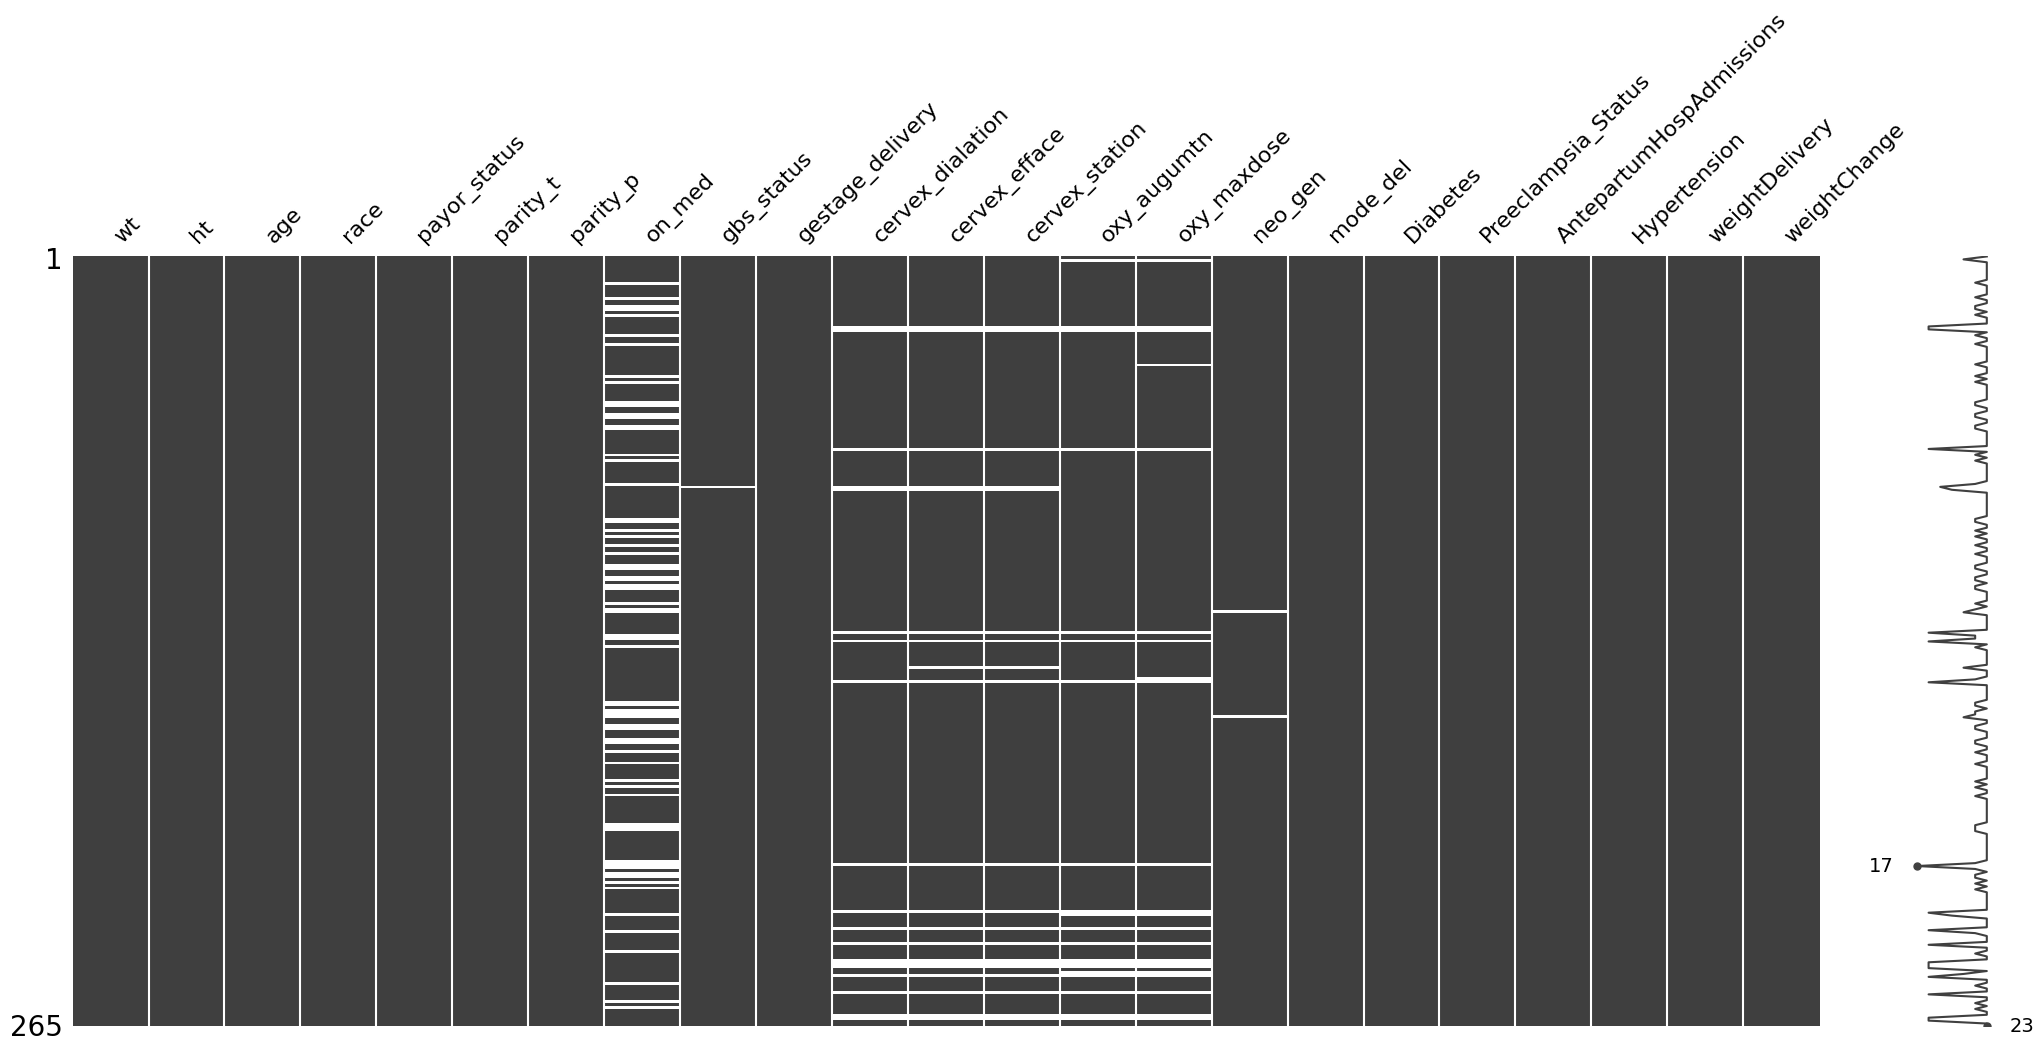

In [43]:
msno.matrix(df) 

<Axes: >

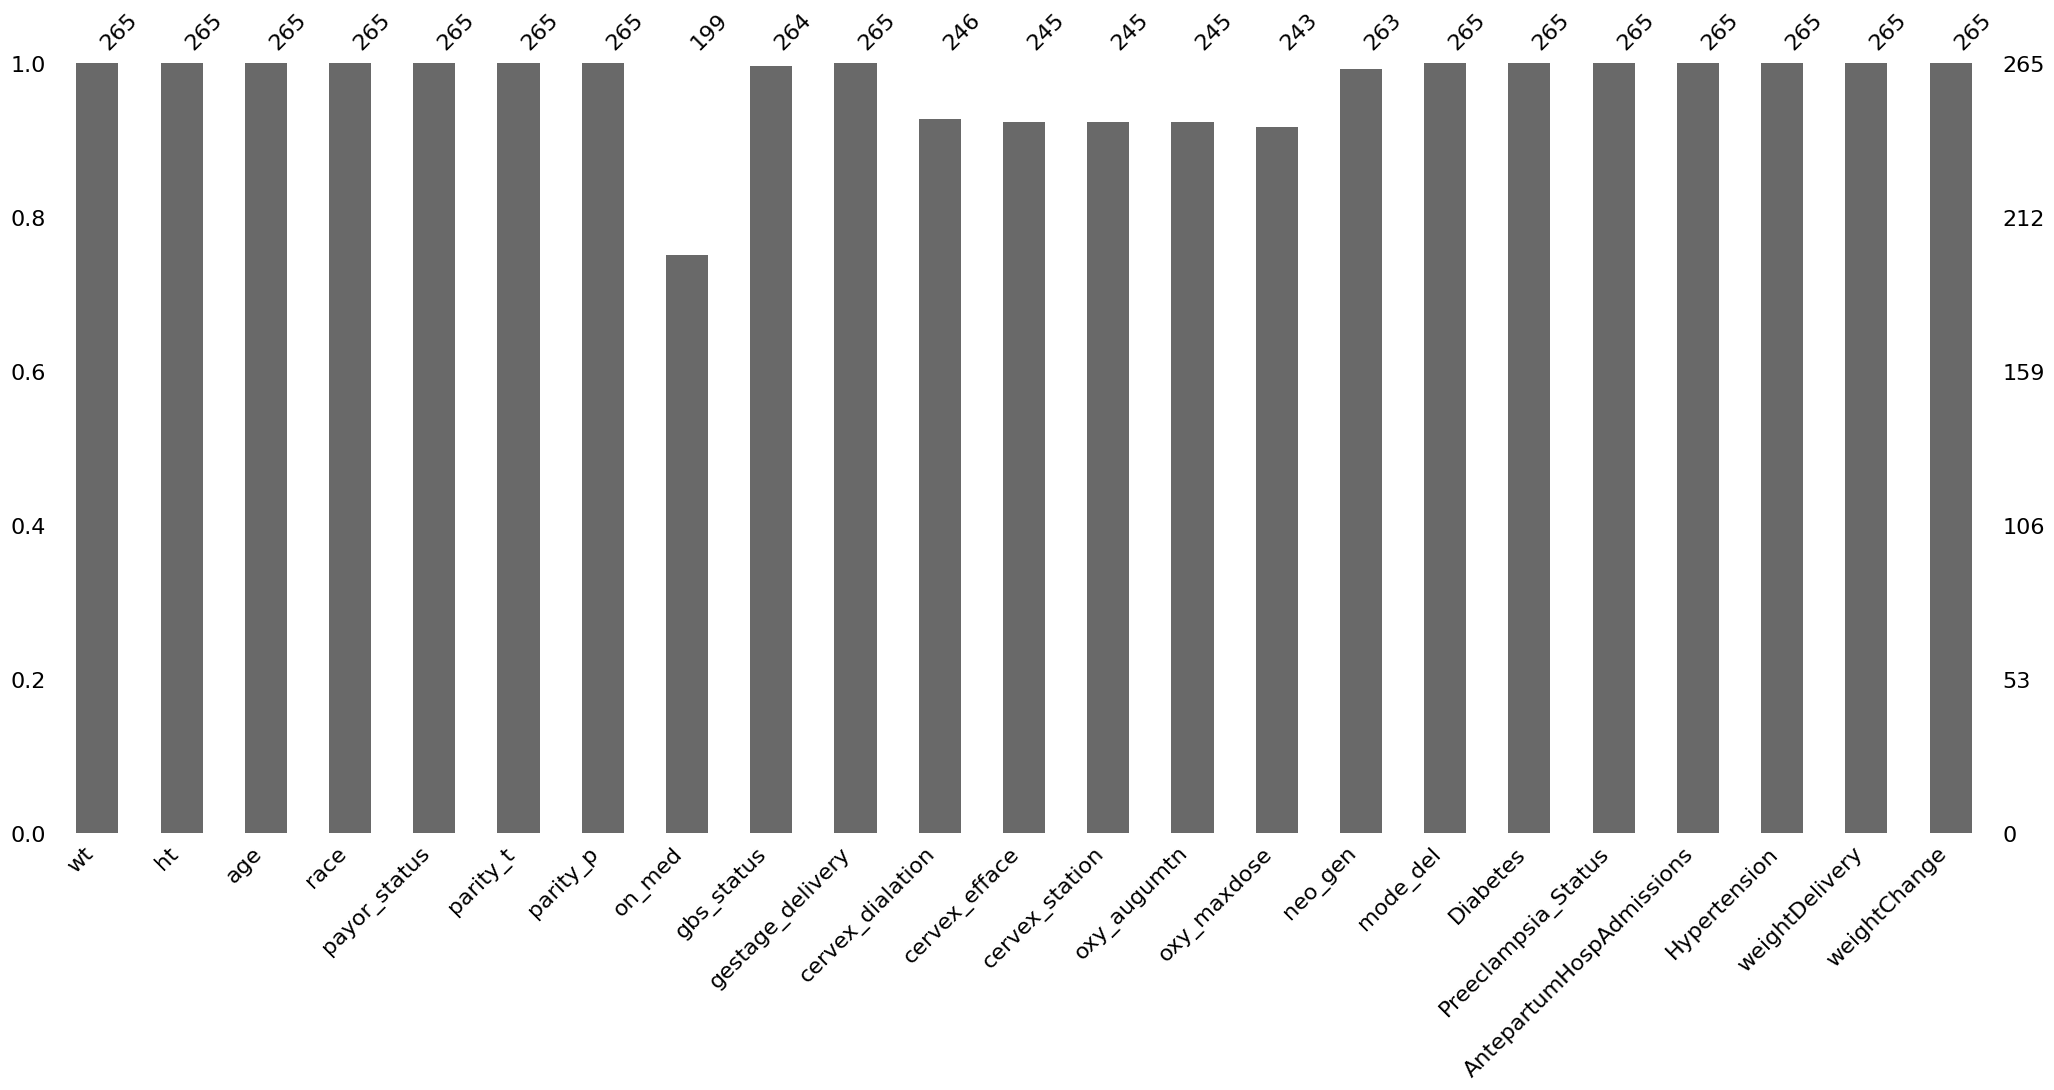

In [46]:
msno.bar(df)

<Axes: >

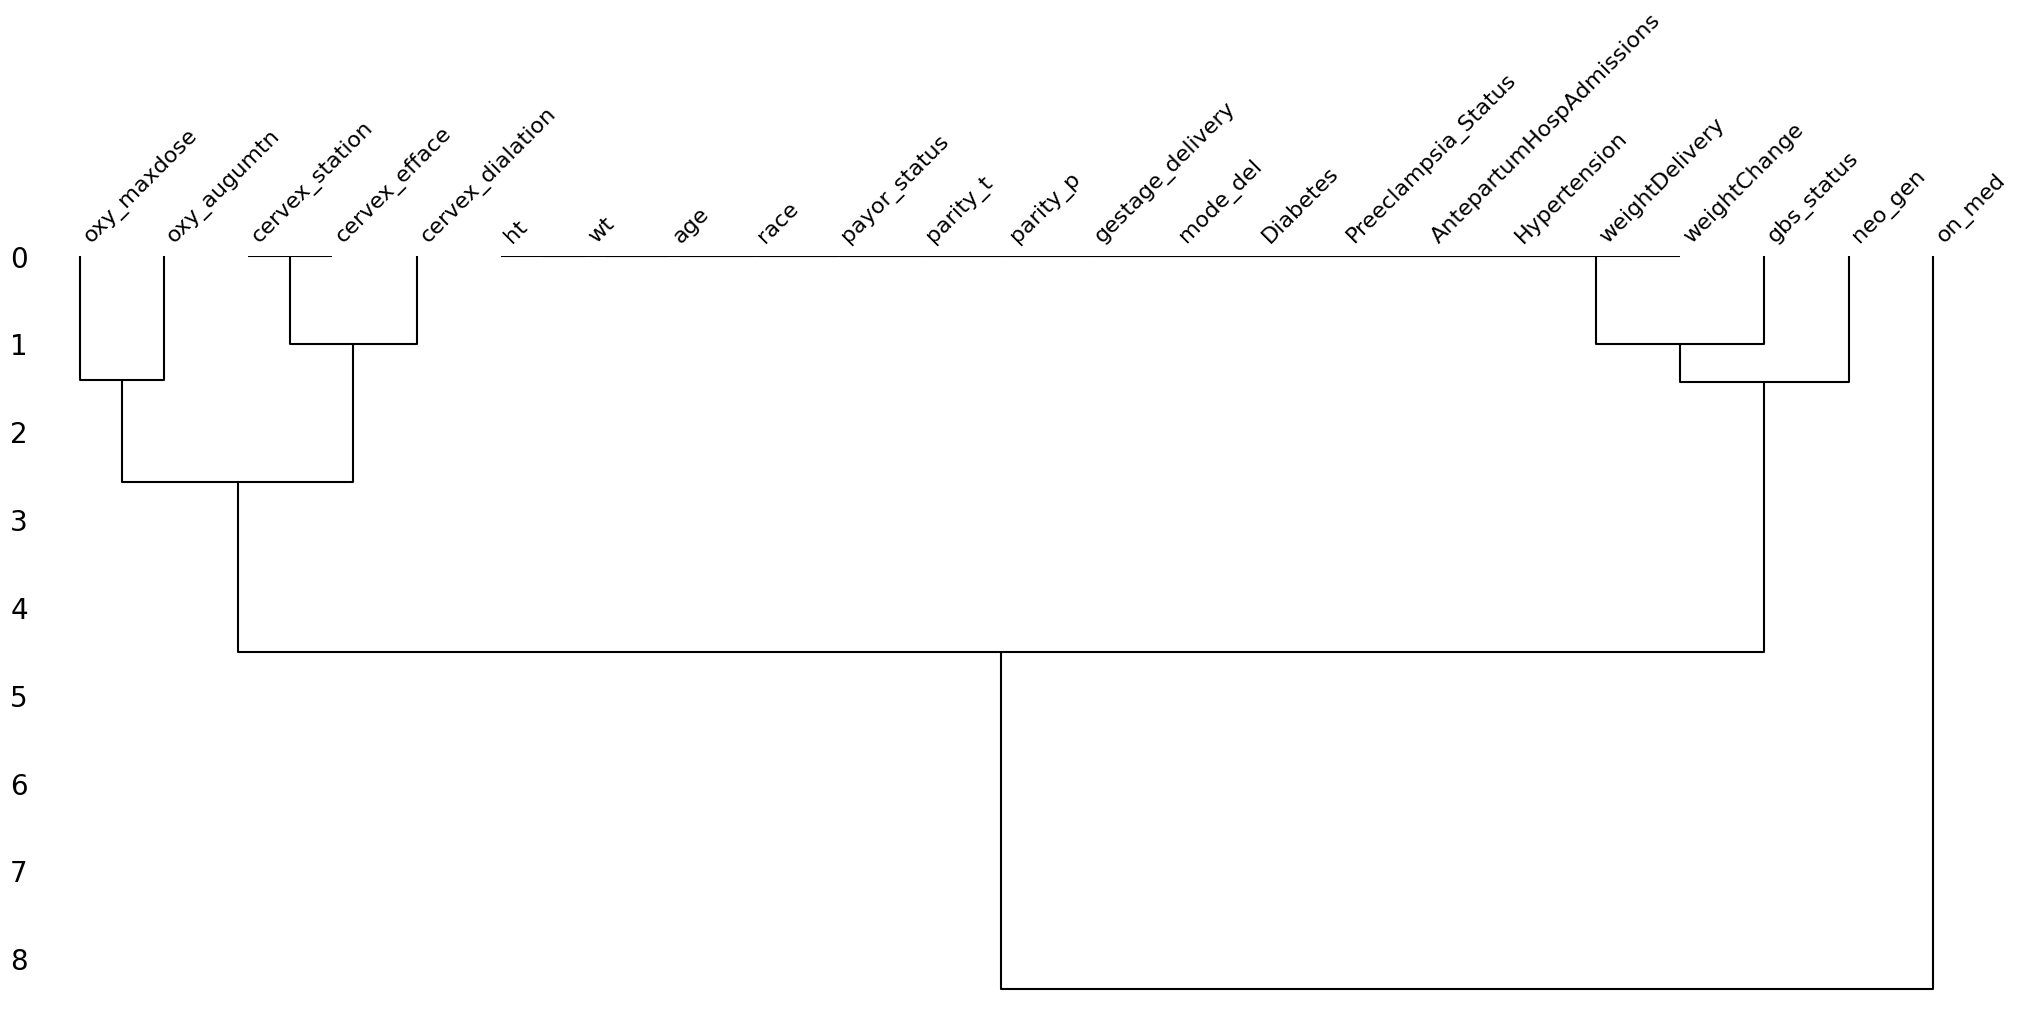

In [47]:
msno.dendrogram(df)

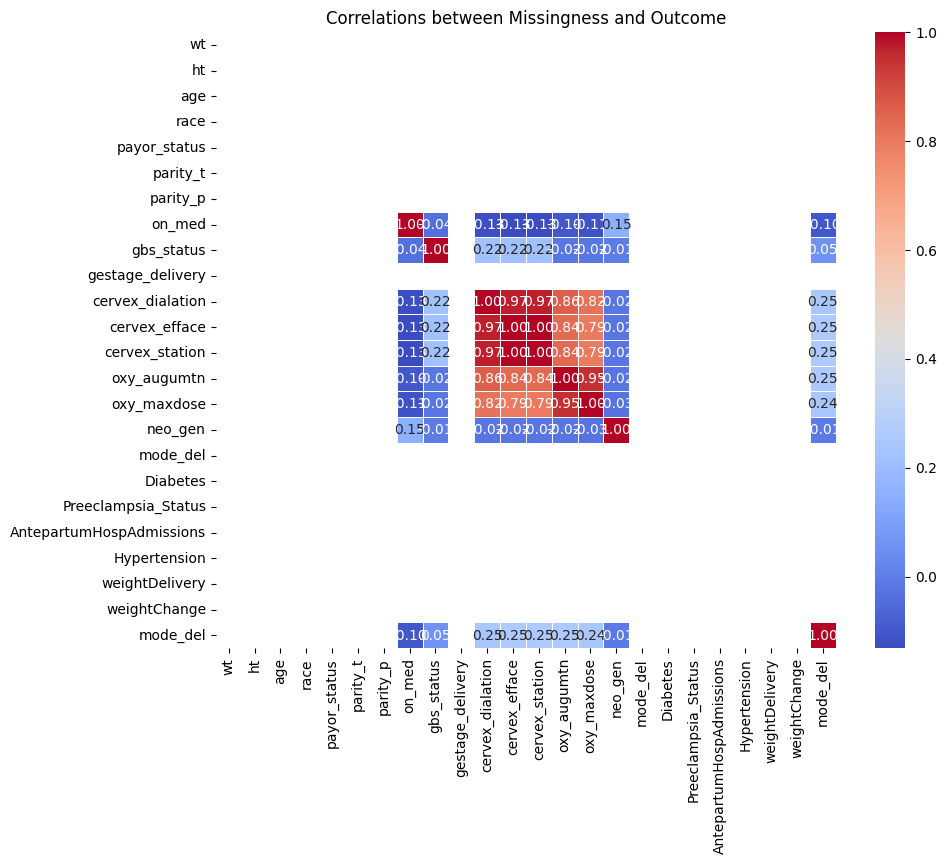

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create a binary indicator for missing values in each column
missing_indicators = {col: df[col].isnull().astype(int) for col in df.columns}

# Create a new DataFrame with missing indicators
missing_df = pd.DataFrame(missing_indicators)

# Combine missing indicators with the outcome variable
combined_df = pd.concat([missing_df, df['mode_del']], axis=1)

# Calculate correlations
correlations = combined_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlations between Missingness and Outcome')
plt.show()


### Multiparous Missingness

<Axes: >

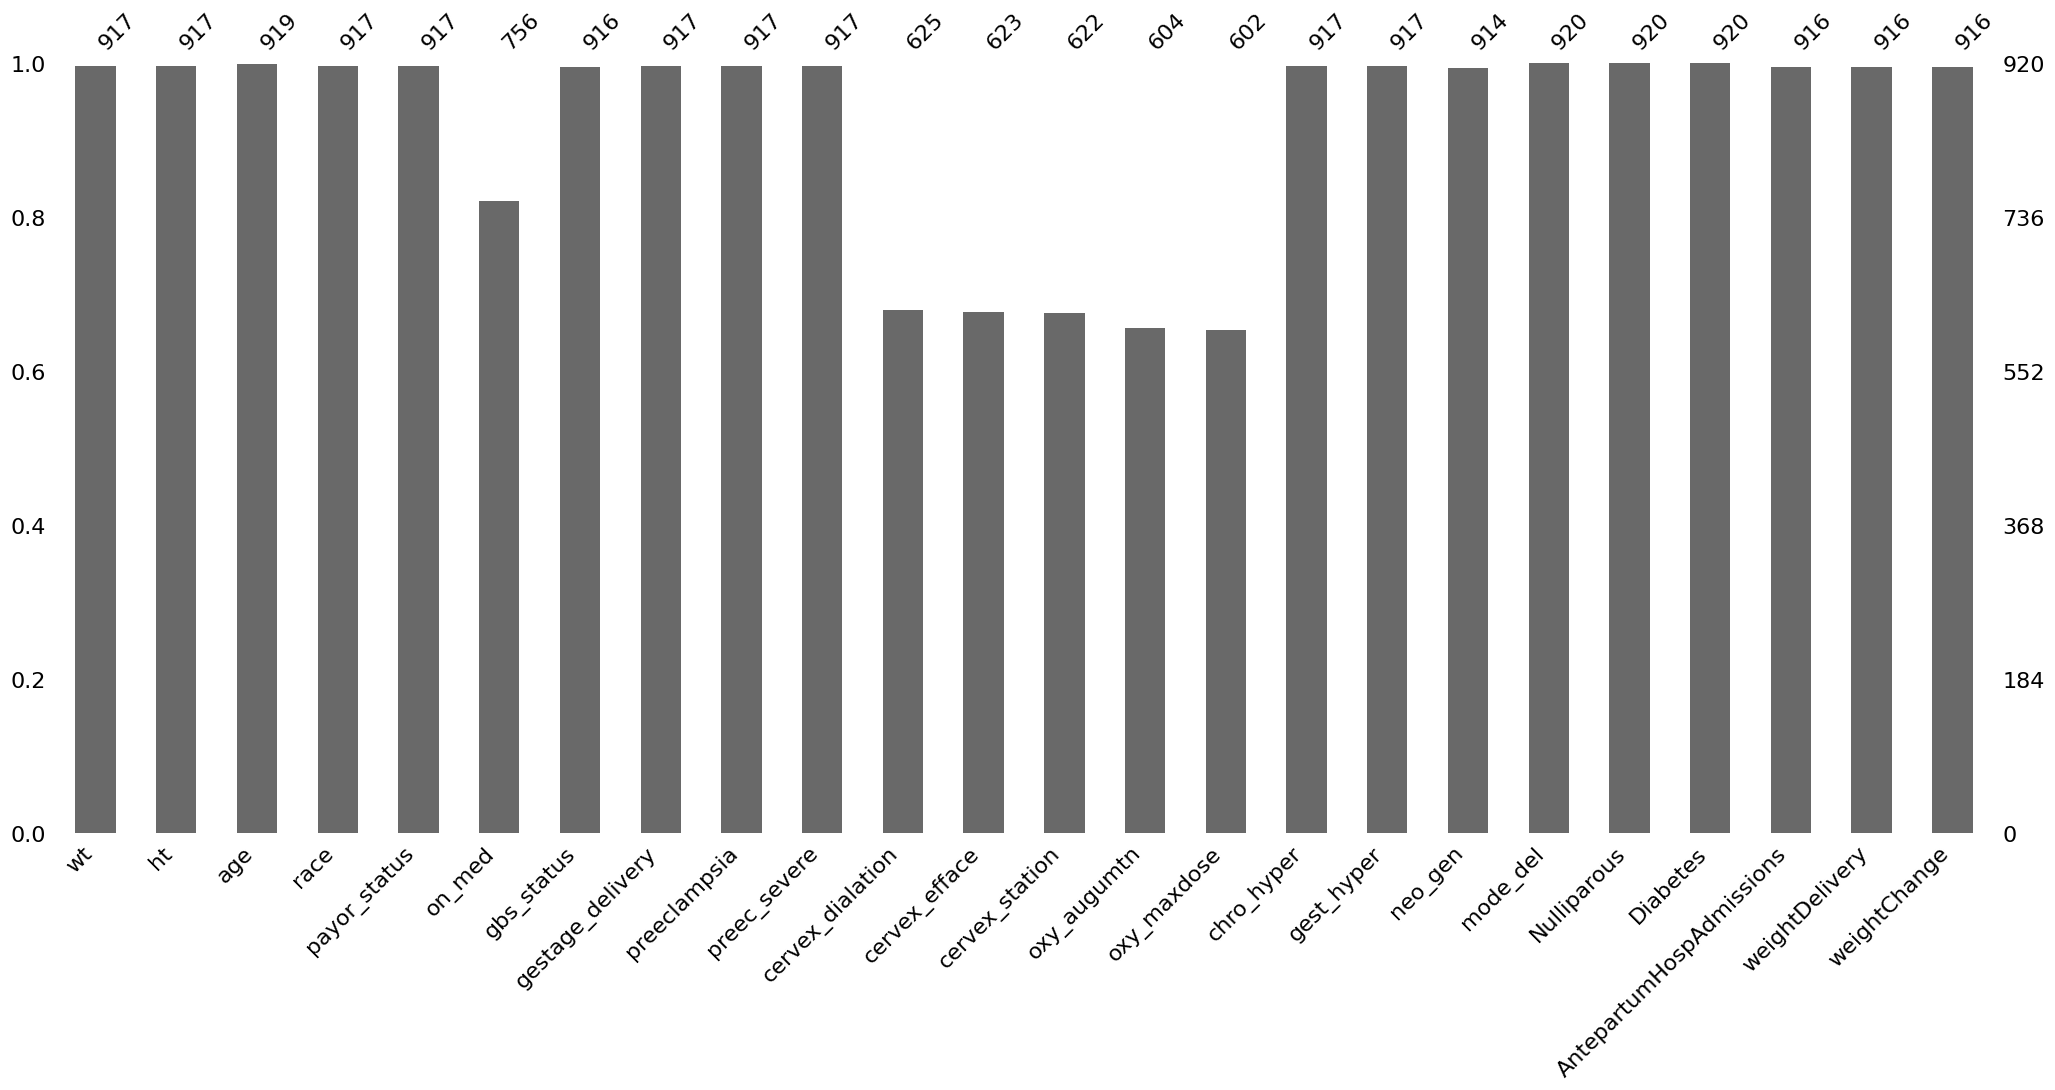

In [51]:
msno.bar(df)

<Axes: >

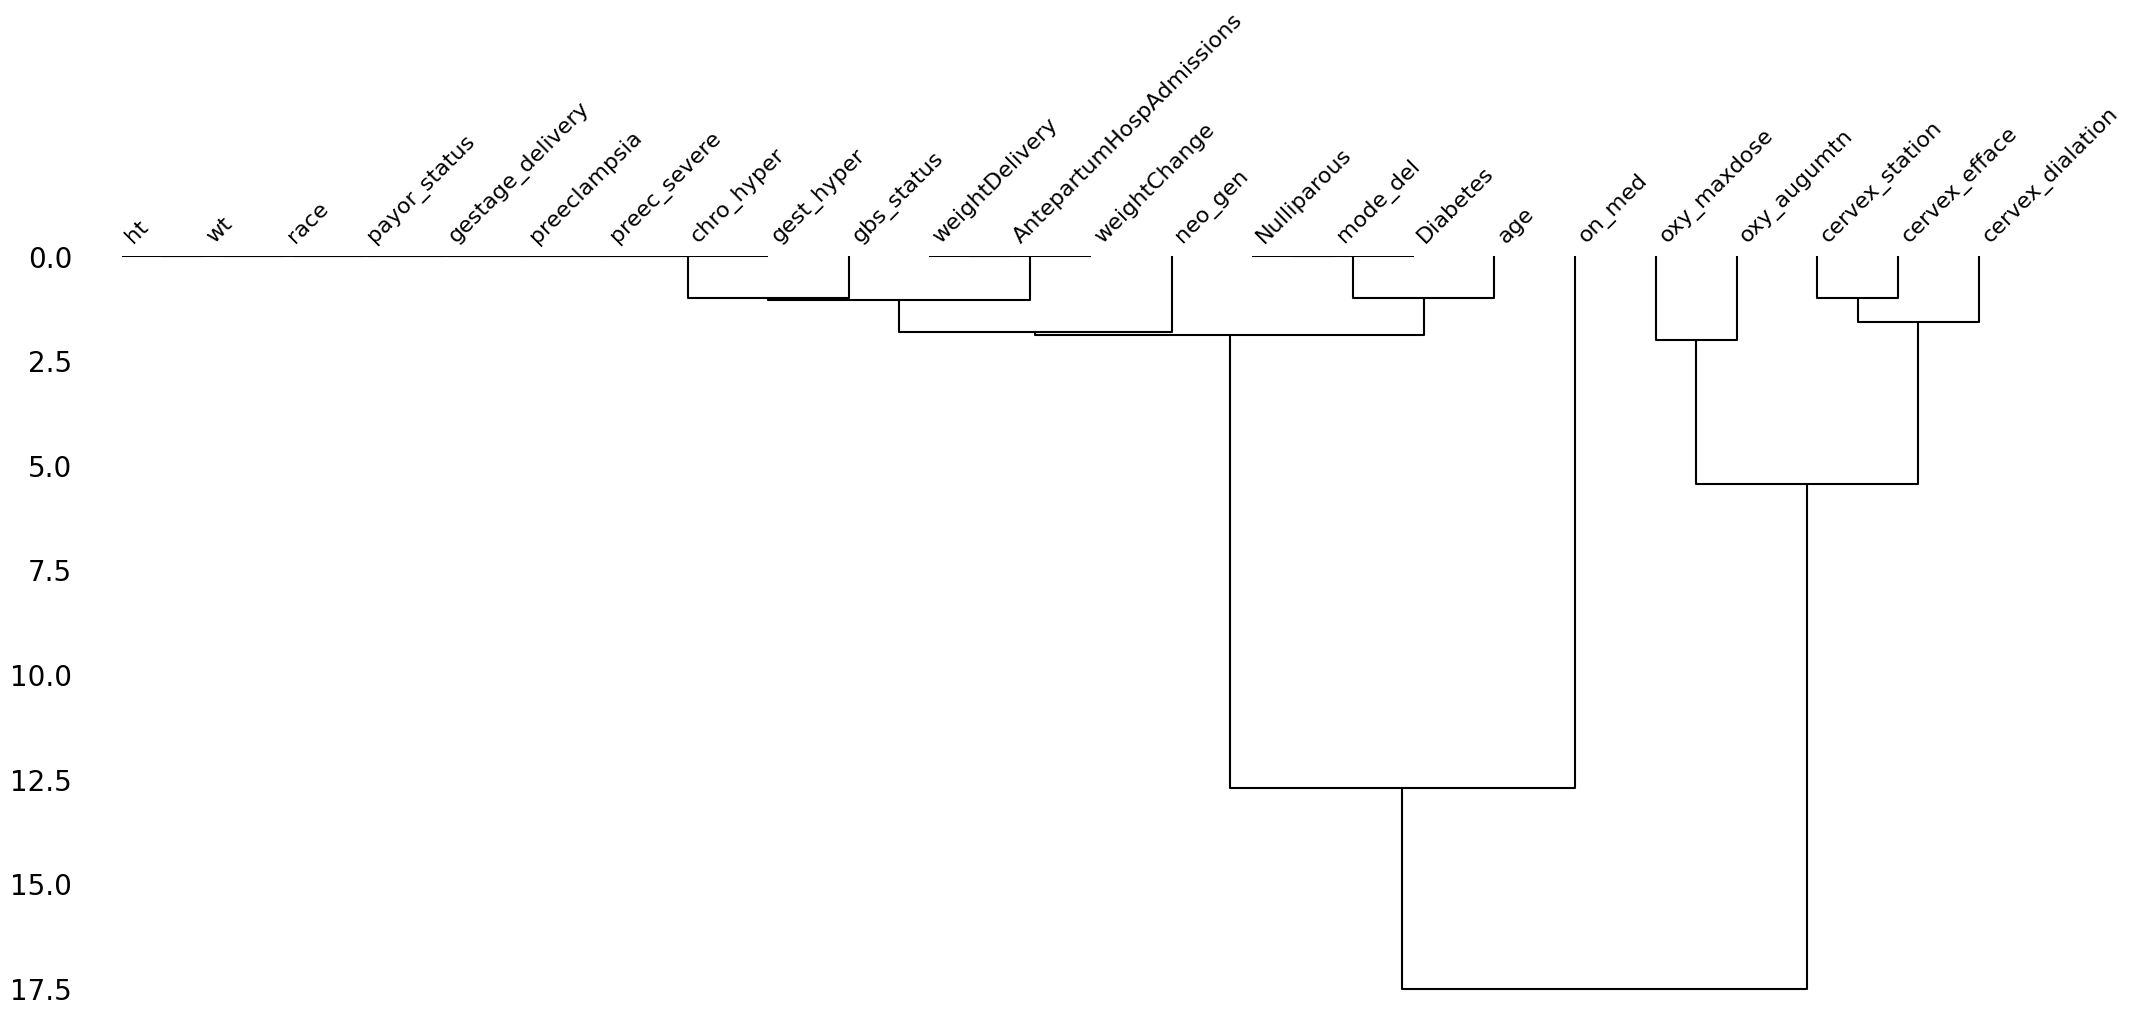

In [52]:
msno.dendrogram(df)

In [43]:
missing.head()

,Weight,Height,Age,Race,Insurance Status,Ripening Method,On Medication (Hypertension),GBS Status,Gest. age at delivery,Preeclampsia,...,Cervix Efface,Cervix Station,Oxy Augmentation,Oxy Max Dose,Neonatal Gender,Cesarean,Diabetes,Antepartum Hosp. Admission,Hypertension,Weight Change
0,221.0,61.0,34,1.0,2.0,0.0,0.0,1.0,277.0,0.0,...,50.0,2.0,0.0,0.0,1.0,0,No Diabetes,1.0,0,14.010526
1,558.0,66.0,28,1.0,2.0,NaN,0.0,3.0,271.0,0.0,...,NaN,NaN,NaN,NaN,1.0,1,No Diabetes,0.0,1,0.286771
2,253.0,62.0,25,1.0,3.0,3.0,0.0,2.0,273.0,0.0,...,0.0,2.0,1.0,20.0,0.0,0,No Diabetes,0.0,1,-0.925462
3,467.0,61.0,36,1.0,2.0,4.0,1.0,2.0,268.0,0.0,...,0.0,2.0,1.0,18.0,0.0,1,Diabetes (Type 2),0.0,1,-0.154765
4,292.0,66.0,23,3.0,2.0,5.0,0.0,2.0,285.0,0.0,...,70.0,2.0,1.0,8.0,0.0,0,No Diabetes,0.0,0,2.943954


In [44]:
missing.isnull().sum()

Weight                            3
Height                            3
Age                               1
Race                              3
Insurance Status                  3
Ripening Method                 315
On Medication (Hypertension)    164
GBS Status                        4
Gest. age at delivery             3
Preeclampsia                      3
Preeclampsia (Severe)             3
Cervix Dilation                 295
Cervix Efface                   297
Cervix Station                  298
Oxy Augmentation                316
Oxy Max Dose                    318
Neonatal Gender                   6
Cesarean                          0
Diabetes                          0
Antepartum Hosp. Admission        4
Hypertension                      0
Weight Change                     4
dtype: int64

In [ ]:
missing.groupby('Age')[]

In [46]:
bool_df = missing.isnull()
#df[bool_df['A'] ^ bool_df['B']].shape[0]
missing[bool_df['Age'] & bool_df['Neonatal Gender']].shape[0]

0

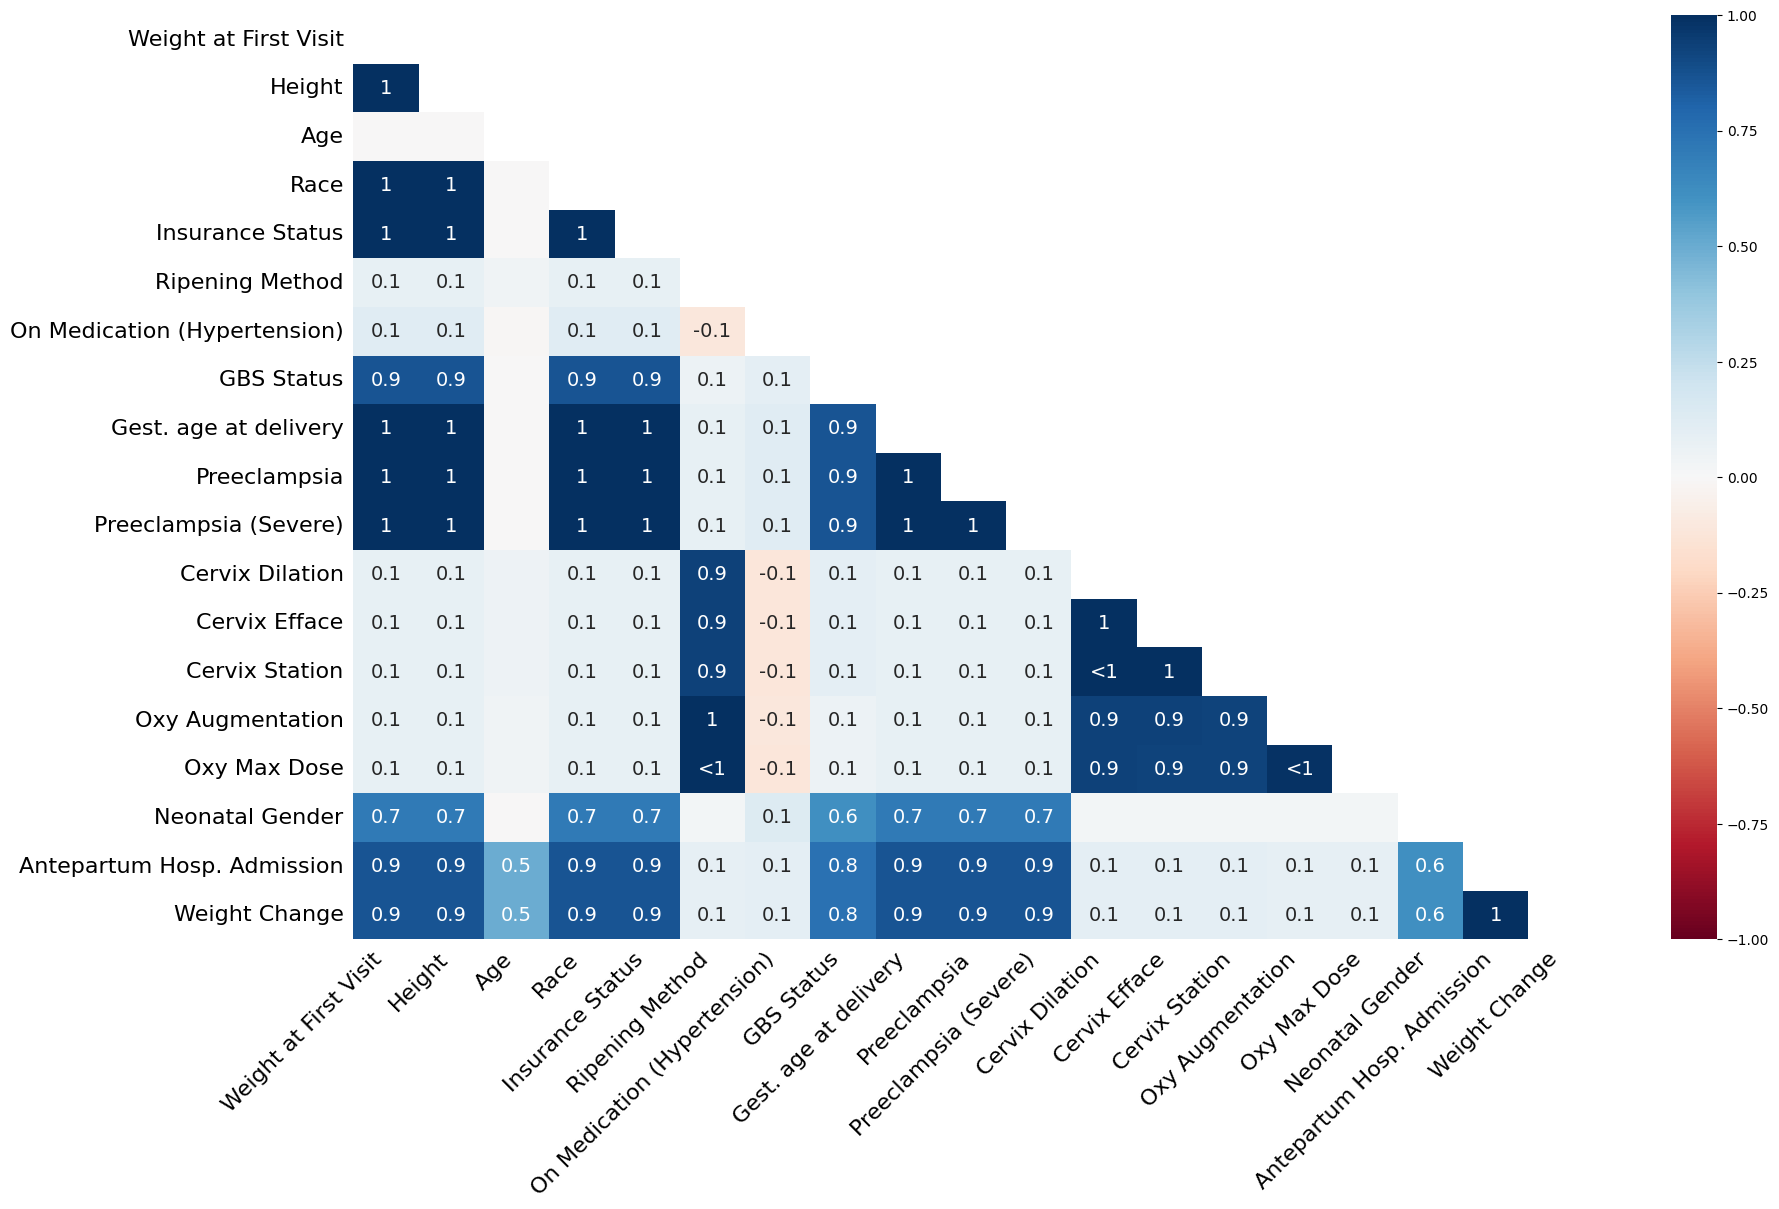

In [49]:

# I want to double check only the columns that have missing values
#nullCols = missing.columns[missing.isnull().any()]

fig = msno.heatmap(missing)
fig_copy = fig.get_figure()
fig_copy.savefig('../Images/20240213Cesarean_missingno_multiparous.png', dpi=400, bbox_inches = "tight")
#fig_copy = fig.get_figure()
#fig_copy.savefig('../Images/Cesarean_missingno_multiparous.png', dpi=400, bbox_inches = "tight")

In [ ]:
# Split the data into a training set and a testing set
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, train_size=0.3)



X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
X_train, y_train = detectOutliers(X_train, y_train, PARAMS)

# 2 - Preprocessing

In [8]:
def prepData(data, labelEncode=None):

    split1 = 5
    split2 = 107

    #if PARAMS['Missing'] == "Drop":
    #    data.dropna(inplace=True)
        
    """
    #labelEncode = ["race", "payor_status", "gbs_status", "neo_gen", "Preeclampsia_Status", "Diabetes"]

    # Label Encode the categorical variables
    data[labelEncode] = data[catEncode].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    """
    X = data.drop(columns='mode_del')
    Y = data['mode_del']

    return X, Y

def normalizeData(X_train, X_test, scaleColumns, PARAMS):

    if PARAMS['Normalize'] == 'MinMax':
        scaler = MinMaxScaler()
    elif PARAMS['Normalize'] == 'StandardScale':
        scaler = StandardScaler()

    # Fit and transform training data, then transform val and test using info gained from fitting

    X_train[scaleColumns] = scaler.fit_transform(X_train[scaleColumns])
    X_test[scaleColumns] = scaler.transform(X_test[scaleColumns])

    return X_train, X_test

def encodeData(X_train, X_test, data, encodeCols, PARAMS):


    selectCat = [c for c in X_train.columns if (c in encodeCols)]

    # If one hot encoding
    list_of_encoded = []

    if PARAMS['Encoding'] == 'OneHotEncode':

        ohe = OneHotEncoder(handle_unknown='ignore')

        X_train[selectCat] = X_train[selectCat].astype("O")
        X_test[selectCat] = X_test[selectCat].astype("O")

        
        # Train on the categorical variables
        ohe.fit(data[selectCat])

        X_trainCodes = ohe.transform(X_train[selectCat]).toarray()
        X_testCodes = ohe.transform(X_test[selectCat]).toarray()
        feature_names = ohe.get_feature_names_out(selectCat)

        X_train = pd.concat([X_train.drop(columns=selectCat).reset_index(drop=True),
                                  pd.DataFrame(X_trainCodes, columns=feature_names).astype(int).reset_index(drop=True)],
                                 axis=1)


        X_test = pd.concat([X_test.drop(columns=selectCat).reset_index(drop=True),
                                 pd.DataFrame(X_testCodes, columns=feature_names).astype(int).reset_index(drop=True)],
                                axis=1)

        # Iterate through the original categorical columns
        for original_col in encodeCols:
            test = str(original_col) + '_'
            # Identify one-hot encoded columns related to the current original column
            encoded_columns = [col for col in X_train.columns if col.startswith(test)]
            
            # Propagate missing values from the 'race_nan' column to one-hot encoded columns
            for encoded_col in encoded_columns:
                #print(str(original_col) + '_nan')
                
                #df.loc[df[str(original_col) + '_nan'] == 1, df.columns.str.startswith(str(encoded_col))] = np.nan
                miss_col = str(original_col) + '_nan'
                if miss_col in X_train.columns:
                    X_train[encoded_col] = X_train[encoded_col].where(~X_train[miss_col].astype(bool), np.NaN)
                    X_test[encoded_col] = X_test[encoded_col].where(~X_test[miss_col].astype(bool), np.NaN)
            
            list_of_encoded.extend(encoded_columns)

        

        # OHE adds unnecessary nan column, which needs to be dropped
        X_train = X_train.loc[:, ~X_train.columns.str.endswith('_nan')]
        X_test = X_test.loc[:, ~X_test.columns.str.endswith('_nan')]

        list_of_encoded = [item for item in list_of_encoded if not item.endswith('_nan')]


    elif PARAMS['Encoding'] == 'Helmert':
        encoder = ce.HelmertEncoder(cols=encodeCols, drop_invariant=True)

        X_train[selectCat] = X_train[selectCat].astype("O")
        X_test[selectCat] = X_test[selectCat].astype("O")

        # Train on the categorical variables
        encoder.fit(data[selectCat])

        X_trainCodes = encoder.transform(X_train[selectCat])
        X_testCodes = encoder.transform(X_test[selectCat])
        feature_names = encoder.get_feature_names_out(selectCat)

        X_train = pd.concat([X_train.drop(columns=selectCat).reset_index(drop=True),
                                  pd.DataFrame(X_trainCodes, columns=feature_names).astype(int).reset_index(
                                      drop=True)],
                                 axis=1)

        X_test = pd.concat([X_test.drop(columns=selectCat).reset_index(drop=True),
                                 pd.DataFrame(X_testCodes, columns=feature_names).astype(int).reset_index(
                                     drop=True)],
                                axis=1)

    elif PARAMS['Encoding'] == 'Hashing':
        encoder = ce.hashing.HashingEncoder(cols=encodeCols, drop_invariant=True)

        X_train[selectCat] = X_train[selectCat].astype("O")
        X_test[selectCat] = X_test[selectCat].astype("O")

        # Train on the categorical variables
        encoder.fit(data[selectCat])

        X_trainCodes = encoder.transform(X_train[selectCat])
        X_testCodes = encoder.transform(X_test[selectCat])
        feature_names = encoder.get_feature_names_out(selectCat)

        X_train = pd.concat([X_train.drop(columns=selectCat).reset_index(drop=True),
                                  pd.DataFrame(X_trainCodes, columns=feature_names).astype(int).reset_index(
                                      drop=True)],
                                 axis=1)

        X_test = pd.concat([X_test.drop(columns=selectCat).reset_index(drop=True),
                                 pd.DataFrame(X_testCodes, columns=feature_names).astype(int).reset_index(
                                     drop=True)],
                                axis=1)

    elif PARAMS['Encoding'] == 'Polynomial':
        encoder = ce.polynomial.PolynomialEncoder(cols=encodeCols, drop_invariant=True)

        X_train[selectCat] = X_train[selectCat].astype("O")
        X_test[selectCat] = X_test[selectCat].astype("O")

        # Train on the categorical variables
        encoder.fit(data[selectCat])

        X_trainCodes = encoder.transform(X_train[selectCat])
        X_testCodes = encoder.transform(X_test[selectCat])
        feature_names = encoder.get_feature_names_out(selectCat)

        X_train = pd.concat([X_train.drop(columns=selectCat).reset_index(drop=True),
                                  pd.DataFrame(X_trainCodes, columns=feature_names).astype(int).reset_index(
                                      drop=True)],
                                 axis=1)

        X_test = pd.concat([X_test.drop(columns=selectCat).reset_index(drop=True),
                                 pd.DataFrame(X_testCodes, columns=feature_names).astype(int).reset_index(
                                     drop=True)],
                                axis=1)

    return X_train, X_test, list_of_encoded

def imputeMissing(X_train, X_test, PARAMS, catCols=None):

    if PARAMS['Missing'] == "BayesianRidge":
        estimator = BayesianRidge()
    elif PARAMS['Missing'] == "DecisionTree":
        estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0)
    elif PARAMS['Missing'] == "ExtraTrees":
        estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
    elif PARAMS['Missing'] == "KNN":
        estimator = KNeighborsRegressor(n_neighbors=5)
    elif PARAMS['Missing'] == "Drop":
        estimator = None

    MI_Imp = IterativeImputer(random_state=0, estimator=estimator, max_iter=10)

    if ((X_train.isnull().values.any() == True)| (X_test.isnull().values.any() == True)) :
        X_train = pd.DataFrame(MI_Imp.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(MI_Imp.transform(X_test), columns=X_test.columns)

        X_train[catCols] = X_train[catCols].round()
        X_test[catCols] = X_test[catCols].round()

    return X_train, X_test

def detectOutliers(X_train, Y_train, PARAMS, con='auto'):

    #print(X_train.shape, Y_train.shape)

    if PARAMS['OutlierRemove'] == 'iso':
        out = IsolationForest(contamination=con)
    elif PARAMS['OutlierRemove'] == 'lof':
        out = LocalOutlierFactor(contamination=con)
    elif PARAMS['OutlierRemove'] == 'ocsvm':
        out = OneClassSVM(nu=0.01)
    elif PARAMS['OutlierRemove'] == 'ee':
        out = EllipticEnvelope()
    else:
        return

    yhat = out.fit_predict(X_train)

    # select all rows that are not outliers
    mask = (yhat != -1)

    X_train = X_train.loc[mask]
    Y_train = Y_train.loc[mask]

    #print(X_train.shape, Y_train.shape)

    return X_train, Y_train

def featureSelection(X_train, X_test, Y_train, PARAMS):

    # If there are less features than the number selected
    numFeatures = min(PARAMS['Feature_Num'], (X_train.shape[1]))

    if PARAMS['Feature_Selection'] == "XGBoost":
        model = XGBClassifier()
        model.fit(X_train, Y_train)

        # Save graph
        ax = plot_importance(model, max_num_features=numFeatures)
        fig1 = pyplot.gcf()
        # pyplot.show()

        fig1.savefig('XGBoostTopFeatures.png', bbox_inches='tight')

        # Get and save best features
        feature_important = model.get_booster().get_fscore()
        keys = list(feature_important.keys())
        values = list(feature_important.values())

        data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
        topFeatures = list(data.index[0:numFeatures])
        X_train = X_train[topFeatures]
        X_test = X_test[topFeatures]

    elif PARAMS['Feature_Selection'] == "Chi2":
        # instantiate SelectKBest to determine 20 best features
        fs = SelectKBest(score_func=chi2, k=numFeatures)
        fs.fit(X_train, Y_train)
        df_scores = pd.DataFrame({"Scores": fs.scores_, "P-values": fs.pvalues_})
        df_columns = pd.DataFrame(X_train.columns)
        # concatenate dataframes
        feature_scores = pd.concat([df_columns, df_scores], axis=1)
        feature_scores.columns = ['Feature_Name', 'Chi2 Score', 'P-value']  # name output columns
        feature_scores.sort_values(by=['Chi2 Score'], ascending=False, inplace=True)
        features = feature_scores.iloc[0:numFeatures]
        chi2Features = features['Feature_Name']
        topFeatures = list(chi2Features)
        Chi2Features = features
        X_train = X_train[topFeatures]
        X_test = X_test[topFeatures]

    elif PARAMS['Feature_Selection'] == "MI":
        # Mutual Information features
        fs = SelectKBest(score_func=mutual_info_classif, k=numFeatures)
        fs.fit(X_train, Y_train)
        df_scores = pd.DataFrame(fs.scores_)
        df_columns = pd.DataFrame(X_train.columns)
        # concatenate dataframes
        feature_scores = pd.concat([df_columns, df_scores], axis=1)
        feature_scores.columns = ['Feature_Name', 'MI Score']  # name output columns
        feature_scores.sort_values(by=['MI Score'], ascending=False, inplace=True)
        features = feature_scores.iloc[0:numFeatures]
        mutualInfoFeatures = features['Feature_Name']
        topFeatures = list(mutualInfoFeatures)
        MIFeatures = features
        X_train = X_train[topFeatures]
        X_test = X_test[topFeatures]

    elif PARAMS['Feature_Selection'] == "RFE":

        estimator = RandomForestClassifier()
        rfe = RFE(estimator, n_features_to_select=numFeatures)
        rfe.fit(X_train, Y_train)

        X_train = rfe.transform(X_train)
        X_test = rfe.transform(X_test)

        topFeatures = rfe.get_feature_names_out()
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
        X_train.columns = topFeatures
        X_test.columns = topFeatures
        RFE_Features = topFeatures
        X_train = X_train[topFeatures]
        X_test = X_test[topFeatures]

    elif PARAMS['Feature_Selection'] == "PCA":
        pca = PCA(n_components=numFeatures)
        X_train = pd.DataFrame(pca.fit_transform(X_train))
        X_test = pd.DataFrame(pca.transform(X_test))
        print(pca.explained_variance_ratio_)
        print("")

    else: # If no feature selection desired
        topFeatures = X_train.columns

    return X_train, X_test

def remove_highly_correlated(X_train, X_test, PARAMS):
    # Create correlation matrix
    corr_matrix = X_train.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        pd.DataFrame(np.triu(np.ones(corr_matrix.shape), k=1), columns=corr_matrix.columns, index=corr_matrix.index)
            .astype(bool))

    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > PARAMS["threshold"])]

    # Remove highly correlated features
    X_train = X_train.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)

    return X_train, X_test

def evaluateModel(X_test, Y_test, model):

    predictions = (model.predict(X_test.values))
    preds = (predictions > 0.5).astype("int32")

    auc = metrics.roc_auc_score(Y_test, preds)
    specificity = specificity_score(Y_test, preds)
    gmean = geometric_mean_score(Y_test, preds)
    recall = metrics.recall_score(Y_test, preds)
    precision = metrics.precision_score(Y_test, preds)
    accuracy = metrics.accuracy_score(Y_test, preds)

    tn, fp, fn, tp = metrics.confusion_matrix(Y_test, predictions).ravel()

    base_fpr = np.linspace(0, 1, 100)
    fpr, tpr, thresholds = roc_curve(Y_test, predictions)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    Results = {"Accuracy": accuracy,
               "AUC": auc,
               "Gmean": gmean,
               "Recall": recall,
               "Precision": precision,
               "Specificity": specificity,
               "True Positives": tp,
               "True Negatives": tn,
               "False Positives": fp,
               "False Negatives": fn,
              "FPR": fpr,
              "TPR": tpr}

    return Results

def condenseResults(modelResults):
    condensed_data = {}
    
    # Iterate through the list of dictionaries
    for entry in modelResults:
        for key, sub_dict in entry.items():
            # If the key doesn't exist in condensed_data, create it with an empty list
            if key not in condensed_data:
                condensed_data[key] = []
    
            # Append the sub_dict to the corresponding entry in condensed_data
            condensed_data[key].append(sub_dict)
    return condensed_data

def meanResults(modelResults):
    # Initialize a new dictionary to store the mean values
    mean_data = {}

    del modelResults['FPR']
    
    # Calculate the mean for each list in the original dictionary
    for key, values in modelResults.items():
        mean_value = sum(values) / len(values)
        mean_data[key] = mean_value

    return mean_data

def prepTuningData(X_train, Y_train, splitCoeff=0.1):

    X_tuneTrain, X_tuneTest, y_tuneTrain, y_tuneTest = train_test_split(X_train, Y_train,
                                                                        test_size=splitCoeff, random_state=42)

    return X_tuneTrain, y_tuneTrain, X_tuneTest, y_tuneTest

def tuneSVM(weight, X_train, Y_train):

    X_tuneTrain, y_tuneTrain, X_tuneTest, y_tuneTest = prepTuningData()

    # The following finds the best alpha for which we get the highest AUC
    alphaSet = np.array([0.01, 0.1, 1, 10, 100, 1000])
    bestAlpha = alphaSet[0]
    bestAUC = 0
    for alpha in alphaSet:
        auc, gmean = runSVM(alpha, X_tuneTrain, y_tuneTrain, X_tuneTest, y_tuneTest)
        if auc > bestAUC:
            bestAlpha = alpha
            bestAUC = auc

    return bestAlpha
    
def runSVM(self, alpha, X_train, Y_Train, X_Test, Y_test=None, weight=False):

    if (Y_test is not None):
        if weight:
            clfSG = SGDClassifier(loss="hinge", max_iter=1000, alpha=alpha, tol=1e-3, class_weight='balanced')
        else:
            clfSG = SGDClassifier(loss="hinge", max_iter=1000, alpha=alpha, tol=1e-3)

        clfSG.fit(X_train, Y_Train)

        predictions = clfSG.predict(X_Test).ravel()
        unique = np.unique(predictions)
        uniqueY = np.unique(Y_test)
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)
        auc_ = metrics.auc(fpr, tpr)
        gmean = geometric_mean_score(Y_test, predictions)

        return auc_, gmean, model

    else:
        if weight:
            clfSG = SGDClassifier(loss="hinge", max_iter=1000, alpha=alpha, tol=1e-3, class_weight='balanced')
        else:
            clfSG = SGDClassifier(loss="hinge", max_iter=1000, alpha=alpha, tol=1e-3)

        clfSG.fit(X_train, Y_train)

        self.predictions = (clfSG.predict(self.X_test))
        preds = pd.DataFrame(self.predictions)

        
    return clfSG

def classify(self, weight):

    preds = self.runSVM(X_train=self.X_train, Y_Train=self.Y_train, X_Test=self.X_test, alpha=self.bestAlpha,
                        weight=weight)
    return preds

In [6]:
df.shape

(920, 25)

In [12]:
df.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'on_med', 'gbs_status',
       'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Diabetes', 'Preeclampsia_Status', 'AntepartumHospAdmissions',
       'Hypertension', 'weightDelivery', 'weightChange'],
      dtype='object')

## 2.5 - Testing Preprocessing

In [46]:
PARAMS = {'Missing': "BayesianRidge",
          'Normalize': "StandardScale",
          'Encoding' : "OneHotEncode",
          'OutlierRemove': "lof",
          'Feature_Num': 100,
          'Feature_Selection': 'MI',
          'threshold': 0.75,
          'Weight': False,
         'Tuning': True}

encodeCols = ["race", "payor_status", "gbs_status"]

scaleColumns = ["wt", "ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions", "weightDelivery", "weightChange"]

X,y = prepData(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=65)

X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
X_train, y_train = detectOutliers(X_train, y_train, PARAMS)


C:\Users\Admin\csec\lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [47]:
mutual_info = mutual_info_classif(X_train, y_train, random_state=42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False, inplace=True)

mutual_info

gbs_status_3.0              0.112066
age                         0.081263
wt                          0.071821
oxy_augumtn                 0.062313
oxy_maxdose                 0.061695
cervex_efface               0.036916
race_1.0                    0.029180
payor_status_2.0            0.025982
Diabetes                    0.021125
neo_gen                     0.020437
parity_t                    0.020154
cervex_dialation            0.008989
weightChange                0.000970
race_3.0                    0.000000
gbs_status_1.0              0.000000
payor_status_1.0            0.000000
race_7.0                    0.000000
race_5.0                    0.000000
race_4.0                    0.000000
AntepartumHospAdmissions    0.000000
race_2.0                    0.000000
Hypertension                0.000000
parity_p                    0.000000
ht                          0.000000
cervex_station              0.000000
gestage_delivery            0.000000
on_med                      0.000000
P

In [50]:
topFeatures = list(mutual_info[mutual_info > 0].index)

X_train_select = X_train[topFeatures]
X_test_select = X_test[topFeatures]

clfSG = SVC(verbose=0)
     
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
#p_grid = {"C": [1, 10, 100]}
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
clf = GridSearchCV(estimator=clfSG, param_grid=p_grid, cv=outer_cv)
clf.fit(X_train_select.values, y_train.values)
bestScores = clf.best_score_
bestParams = clf.best_params_
bestModel = clf.best_estimator_
Results = evaluateModel(X_test_select, y_test, bestModel)
Results

{'C': 1, 'gamma': 0.1}

In [55]:
mutual_info[0:10].index

Index(['gbs_status_3.0', 'age', 'wt', 'oxy_augumtn', 'oxy_maxdose',
       'cervex_efface', 'race_1.0', 'payor_status_2.0', 'Diabetes', 'neo_gen'],
      dtype='object')

In [63]:
topFeatures = list(mutual_info[0:9].index)

X_train_select = X_train[topFeatures]
X_test_select = X_test[topFeatures]

clfSG = SVC(verbose=0)
     
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
#p_grid = {"C": [1, 10, 100]}
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
clf = GridSearchCV(estimator=clfSG, param_grid=p_grid, cv=outer_cv)
clf.fit(X_train_select.values, y_train.values)
bestScores = clf.best_score_
bestParams = clf.best_params_
bestModel = clf.best_estimator_
Results = evaluateModel(X_test_select, y_test, bestModel)
Results

{'Accuracy': 0.6716417910447762,
 'AUC': 0.6575091575091575,
 'Gmean': 0.6518500018473766,
 'Recall': 0.7435897435897436,
 'Precision': 0.7073170731707317,
 'Specificity': 0.5714285714285714,
 'True Positives': 29,
 'True Negatives': 16,
 'False Positives': 12,
 'False Negatives': 10,
 'FPR': array([0.        , 0.42857143, 1.        ]),
 'TPR': array([0.        , 0.01752568, 0.03505137, 0.05257705, 0.07010274,
        0.08762842, 0.10515411, 0.12267979, 0.14020547, 0.15773116,
        0.17525684, 0.19278253, 0.21030821, 0.22783389, 0.24535958,
        0.26288526, 0.28041095, 0.29793663, 0.31546232, 0.332988  ,
        0.35051368, 0.36803937, 0.38556505, 0.40309074, 0.42061642,
        0.4381421 , 0.45566779, 0.47319347, 0.49071916, 0.50824484,
        0.52577053, 0.54329621, 0.56082189, 0.57834758, 0.59587326,
        0.61339895, 0.63092463, 0.64845032, 0.665976  , 0.68350168,
        0.70102737, 0.71855305, 0.73607874, 0.74617975, 0.75071225,
        0.75524476, 0.75977726, 0.76430976

In [51]:
bestScores

0.6060204081632653

In [80]:
clfSG = SVC(verbose=0)
     
p_grid = {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001]}
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
clf = GridSearchCV(estimator=clfSG, param_grid=p_grid, cv=outer_cv)
clf.fit(X_train.values, y_train.values)
bestScores = clf.best_score_
bestParams = clf.best_params_
bestModel = clf.best_estimator_
Results = evaluateModel(X_test, y_test, bestModel)
Results

{'Accuracy': 0.6153846153846154,
 'AUC': 0.6303030303030303,
 'Gmean': 0.6227991553292184,
 'Recall': 0.5333333333333333,
 'Precision': 0.7272727272727273,
 'Specificity': 0.7272727272727273,
 'True Positives': 8,
 'True Negatives': 8,
 'False Positives': 3,
 'False Negatives': 7,
 'FPR': array([0.        , 0.27272727, 1.        ]),
 'TPR': array([0.        , 0.01975309, 0.03950617, 0.05925926, 0.07901235,
        0.09876543, 0.11851852, 0.1382716 , 0.15802469, 0.17777778,
        0.19753086, 0.21728395, 0.23703704, 0.25679012, 0.27654321,
        0.2962963 , 0.31604938, 0.33580247, 0.35555556, 0.37530864,
        0.39506173, 0.41481481, 0.4345679 , 0.45432099, 0.47407407,
        0.49382716, 0.51358025, 0.53333333, 0.53981481, 0.5462963 ,
        0.55277778, 0.55925926, 0.56574074, 0.57222222, 0.5787037 ,
        0.58518519, 0.59166667, 0.59814815, 0.60462963, 0.61111111,
        0.61759259, 0.62407407, 0.63055556, 0.63703704, 0.64351852,
        0.65      , 0.65648148, 0.66296296, 0.

In [81]:
bestParams

{'C': 10, 'gamma': 0.01}

In [82]:
clfSG = SVC(C=1000, gamma= 1,verbose=0)
     
p_grid = {"C": [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001]}
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
clfSG.fit(X_train.values, y_train.values)
bestScores = clf.best_score_
bestParams = clf.best_params_
bestModel = clf.best_estimator_
Results = evaluateModel(X_test, y_test, clfSG)
Results

{'Accuracy': 0.5384615384615384,
 'AUC': 0.4666666666666667,
 'Gmean': 0.0,
 'Recall': 0.9333333333333333,
 'Precision': 0.56,
 'Specificity': 0.0,
 'True Positives': 14,
 'True Negatives': 0,
 'False Positives': 11,
 'False Negatives': 1,
 'FPR': array([0., 1., 1.]),
 'TPR': array([0.        , 0.00942761, 0.01885522, 0.02828283, 0.03771044,
        0.04713805, 0.05656566, 0.06599327, 0.07542088, 0.08484848,
        0.09427609, 0.1037037 , 0.11313131, 0.12255892, 0.13198653,
        0.14141414, 0.15084175, 0.16026936, 0.16969697, 0.17912458,
        0.18855219, 0.1979798 , 0.20740741, 0.21683502, 0.22626263,
        0.23569024, 0.24511785, 0.25454545, 0.26397306, 0.27340067,
        0.28282828, 0.29225589, 0.3016835 , 0.31111111, 0.32053872,
        0.32996633, 0.33939394, 0.34882155, 0.35824916, 0.36767677,
        0.37710438, 0.38653199, 0.3959596 , 0.40538721, 0.41481481,
        0.42424242, 0.43367003, 0.44309764, 0.45252525, 0.46195286,
        0.47138047, 0.48080808, 0.49023569, 

In [77]:
predictions = (bestModel.predict(X_test.values))
preds = (predictions > 0.5).astype("int32")

#auc = metrics.roc_auc_score(Y_test, preds)
#specificity = specificity_score(Y_test, preds)
gmean = geometric_mean_score(y_test, preds)
gmean

0.6227991553292184

# 3 - Modeling

In [16]:
PARAMS = {'Missing': "BayesianRidge",
          'Normalize': "StandardScale",
          'Encoding' : "OneHotEncode",
          'OutlierRemove': "lof",
          'Feature_Num': 100,
          'Feature_Selection': 'None',
          'threshold': 0.75,
          'Weight': False,
         'Tuning': True}

# Which categorical variables need to be label encoded for imputation? 
#catEncode = ["race", "payor_status", "gbs_status", "neo_gen", "Preeclampsia_Status", "Diabetes"]
# Which variables need to be encoded? 
#encodeCols = ["race", "payor_status", "gbs_status", "Diabetes","spcy_ripen"]
encodeCols = ["race", "payor_status", "gbs_status"]

scaleColumns = ["wt", "ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions", "weightChange"]

In [103]:
df.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'on_med', 'gbs_status',
       'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'mode_del',
       'Diabetes', 'Preeclampsia_Status', 'AntepartumHospAdmissions',
       'Hypertension', 'weightDelivery', 'weightChange'],
      dtype='object')

In [14]:
PARAMS = {'Missing': "BayesianRidge",
          'Normalize': "StandardScale",
          'Encoding' : "OneHotEncode",
          'OutlierRemove': "lof",
          'Feature_Num': 100,
          'Feature_Selection': 'None',
          'threshold': 1,
          'Weight': False,
         'Tuning': True}

# Which categorical variables need to be label encoded for imputation? 
#catEncode = ["race", "payor_status", "gbs_status", "neo_gen", "Preeclampsia_Status", "Diabetes"]
# Which variables need to be encoded? 
#encodeCols = ["race", "payor_status", "gbs_status", "Diabetes","spcy_ripen"]

encodeCols = ["race", "payor_status", "gbs_status"]

#scaleColumns = ["wt", "ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
#                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions", "weightDelivery", "weightChange"]

scaleColumns = ["wt", "ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions", "weightChange"]

#df['bmiChange'] = df['pre_bmi'] - df['bmi_delivery']
#scaleColumns = ["ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
#                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions", "weightChange", "bmiChange"]

#scaleColumns = ["ht", "age", "gestage_delivery", "cervex_dialation","cervex_efface",
#                "cervex_station", "oxy_maxdose", "AntepartumHospAdmissions",  "bmiChange", "pre_bmi", "bmi_delivery"]

# For imputing one-hot-encoded categorical values 
#catEncode = ["oxy_augumtn", "neo_gen", "gbs_status", "cervex_station"]

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
xYDict = {}
counter = 1

X,y = prepData(df)


ResultsDict = {"LogReg": [],
               "SVMRBF": [],
               "SVMLin" :[],
               "XGBoost": [], 
               "RF": [],
               "KNN": [],
               "NB": []}
"""

ResultsDict = {"LogReg": [],
               #"SVMRBF": []}
               #"SVMLin" :[],
               #"XGBoost": [], 
               "RF": []}
               #"KNN": [],
               #"NB": []}

"""

hyper = {'n_estimators': 1600,
                 'min_samples_split': 2,
                 'min_samples_leaf': 4,
                 'max_features': 'sqrt',
                 'max_depth': 10,
                 'bootstrap': True}


i = 0
for train_index, test_index in rskf.split(X, y):
    print(i)
    # Split Data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    #print(f'Train Positives: {y_train.sum()}')
    #print(f'Test Positives: {y_test.sum()}')

    # If performing Hyperparameter Tuning. Functionally, this is nested CV. 
    # Risks overfitting if sample is too small. 
    #X_tuneTrain, y_tuneTrain, X_tuneTest, y_tuneTest =  prepTuningData(X_train, Y_train, splitCoeff=0.1)

    # Prep Data --------------------------------------------------------------------------
    
    X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
    X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
    X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
    #X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
    X_train, y_train = detectOutliers(X_train, y_train, PARAMS)

    #X_train.drop(columns=['Diabetes_No Diabetes'], inplace=True)
    #X_test.drop(columns=['Diabetes_No Diabetes'], inplace=True)

    #print(X_train.columns)

    # Train Models ------------------------------------------------------------------------
    
    
    if PARAMS['Weight'] == False:
        logReg = LogisticRegression(max_iter=3000)

    else:
        logReg = LogisticRegression(max_iter=3000, class_weight='balanced')   
        
    logReg.fit(X_train.values, y_train.values)
    Results = evaluateModel(X_test, y_test, logReg)
    ResultsDict["LogReg"].append(Results)
    
    
    if PARAMS['Weight'] == False:
        clfSG = SVC(verbose=0)
    else:
        clfSG = SVC(verbose=0, class_weight='balanced')   
    #clfSG.fit(X_train.values, y_train.values)
    #Results = evaluateModel(X_test, y_test, clfSG)
    #ResultsDict["SVMRBF"].append(Results)
   
    
    p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=clfSG, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["SVMRBF"].append(Results)

    #print("Grid Search Results:")
    #print("Best Parameters:", bestParams)
    #print("Best Cross-Validation Score:", bestScores)
    
    
    
    
    if PARAMS['Weight'] == False:
        xgb = XGBClassifier()
    else:
        positive = sum(y_train.values) # number of positive class
        negative = len(y_train.values) - positive
        test = negative/(positive + 1)
        xgb = XGBClassifier(scale_pos_weight=test)
        
    #xgb.fit(X_train.values, y_train.values)
    #Results = evaluateModel(X_test, y_test, xgb)
    #ResultsDict["XGBoost"].append(Results)
    
    
    p_grid = {"max_depth": [1, 3, 5, 10], "n_estimators": [100, 200, 500, 1000], "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=xgb, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["XGBoost"].append(Results)
    
   
    if PARAMS['Weight'] == False:
        rf = RandomForestClassifier(n_estimators=hyper['n_estimators'],
                                                min_samples_split=hyper['min_samples_split'],
                                                min_samples_leaf=hyper['min_samples_leaf'],
                                                max_features=hyper['max_features'],
                                                max_depth=hyper['max_depth'],
                                                bootstrap=hyper['bootstrap'])
    else:
        rf = RandomForestClassifier(class_weight='balanced',
                                    n_estimators=hyper['n_estimators'],
                                    min_samples_split=hyper['min_samples_split'],
                                    min_samples_leaf=hyper['min_samples_leaf'],
                                    max_features=hyper['max_features'],
                                    max_depth=hyper['max_depth'],
                                    bootstrap=hyper['bootstrap'])
        
    """
    p_grid = {"max_depth": [1, 3, 5, 10], "n_estimators": [100, 200, 500, 1000], "max_features":['sqrt', 'log2']}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["RF"].append(Results)
    
    """
    
    rf.fit(X_train.values, y_train.values)
    Results = evaluateModel(X_test, y_test, rf)
    ResultsDict["RF"].append(Results)
    
    
    
    if PARAMS['Weight'] == False:
        svmLin = SGDClassifier(loss="hinge", max_iter=1000, alpha=1, tol=1e-3)
    else:
        svmLin = SGDClassifier(class_weight='balanced',loss="hinge", max_iter=1000, alpha=1, tol=1e-3)
    
    #svmLin.fit(X_train.values, y_train.values)    
    #Results = evaluateModel(X_test, y_test, svmLin)
    #ResultsDict["SVMLin"].append(Results)
    

    p_grid = {"alpha": [0.01, 0.1, 1, 10, 100, 1000]}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=svmLin, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["SVMLin"].append(Results)
    
    
    knn = KNeighborsClassifier() 
    #knn.fit(X_train.values, y_train.values)
    #Results = evaluateModel(X_test, y_test, knn)
    #ResultsDict["KNN"].append(Results)

    p_grid = {"n_neighbors": [1, 3, 5, 10]}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=knn, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["KNN"].append(Results)
    
    
    nb = GaussianNB()
    #nb.fit(X_train.values, y_train.values)
    #Results = evaluateModel(X_test, y_test, nb)
    #ResultsDict["NB"].append(Results)

    p_grid = {"var_smoothing": [1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09]}
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
    clf = GridSearchCV(estimator=nb, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_train.values, y_train.values)
    bestScores = clf.best_score_
    bestParams = clf.best_params_
    bestModel = clf.best_estimator_
    Results = evaluateModel(X_test, y_test, bestModel)
    ResultsDict["NB"].append(Results)

    i+=1

0


[IterativeImputer] Early stopping criterion not reached.


1


[IterativeImputer] Early stopping criterion not reached.


2


[IterativeImputer] Early stopping criterion not reached.


3


[IterativeImputer] Early stopping criterion not reached.


4


[IterativeImputer] Early stopping criterion not reached.


5


[IterativeImputer] Early stopping criterion not reached.


6


[IterativeImputer] Early stopping criterion not reached.


7


[IterativeImputer] Early stopping criterion not reached.


8


[IterativeImputer] Early stopping criterion not reached.


9


[IterativeImputer] Early stopping criterion not reached.


10


[IterativeImputer] Early stopping criterion not reached.


11


[IterativeImputer] Early stopping criterion not reached.


12


[IterativeImputer] Early stopping criterion not reached.


13


[IterativeImputer] Early stopping criterion not reached.


14


[IterativeImputer] Early stopping criterion not reached.


15


[IterativeImputer] Early stopping criterion not reached.


16


[IterativeImputer] Early stopping criterion not reached.


17


[IterativeImputer] Early stopping criterion not reached.


18


[IterativeImputer] Early stopping criterion not reached.


19


[IterativeImputer] Early stopping criterion not reached.


20


[IterativeImputer] Early stopping criterion not reached.


21


[IterativeImputer] Early stopping criterion not reached.


22


[IterativeImputer] Early stopping criterion not reached.


23


[IterativeImputer] Early stopping criterion not reached.


24


[IterativeImputer] Early stopping criterion not reached.


25


[IterativeImputer] Early stopping criterion not reached.


26


[IterativeImputer] Early stopping criterion not reached.


27


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


29


[IterativeImputer] Early stopping criterion not reached.


30


[IterativeImputer] Early stopping criterion not reached.


31


[IterativeImputer] Early stopping criterion not reached.


32


[IterativeImputer] Early stopping criterion not reached.


33


[IterativeImputer] Early stopping criterion not reached.


34


[IterativeImputer] Early stopping criterion not reached.


35


[IterativeImputer] Early stopping criterion not reached.


36


[IterativeImputer] Early stopping criterion not reached.


37


[IterativeImputer] Early stopping criterion not reached.


38


[IterativeImputer] Early stopping criterion not reached.


39


[IterativeImputer] Early stopping criterion not reached.


40


[IterativeImputer] Early stopping criterion not reached.


41


[IterativeImputer] Early stopping criterion not reached.


42


[IterativeImputer] Early stopping criterion not reached.


43


[IterativeImputer] Early stopping criterion not reached.


44


[IterativeImputer] Early stopping criterion not reached.


45


[IterativeImputer] Early stopping criterion not reached.


46


[IterativeImputer] Early stopping criterion not reached.


47


[IterativeImputer] Early stopping criterion not reached.


48


[IterativeImputer] Early stopping criterion not reached.


49


[IterativeImputer] Early stopping criterion not reached.


50


[IterativeImputer] Early stopping criterion not reached.


51


[IterativeImputer] Early stopping criterion not reached.


52


[IterativeImputer] Early stopping criterion not reached.


53


[IterativeImputer] Early stopping criterion not reached.


54


[IterativeImputer] Early stopping criterion not reached.


55


[IterativeImputer] Early stopping criterion not reached.


56


[IterativeImputer] Early stopping criterion not reached.


57


[IterativeImputer] Early stopping criterion not reached.


58


[IterativeImputer] Early stopping criterion not reached.


59


[IterativeImputer] Early stopping criterion not reached.


60


[IterativeImputer] Early stopping criterion not reached.


61


[IterativeImputer] Early stopping criterion not reached.


62


[IterativeImputer] Early stopping criterion not reached.


63


[IterativeImputer] Early stopping criterion not reached.


64


[IterativeImputer] Early stopping criterion not reached.


65


[IterativeImputer] Early stopping criterion not reached.


66


[IterativeImputer] Early stopping criterion not reached.


67


[IterativeImputer] Early stopping criterion not reached.


68


[IterativeImputer] Early stopping criterion not reached.


69


[IterativeImputer] Early stopping criterion not reached.


70


[IterativeImputer] Early stopping criterion not reached.


71


[IterativeImputer] Early stopping criterion not reached.


72


[IterativeImputer] Early stopping criterion not reached.


73


[IterativeImputer] Early stopping criterion not reached.


74


[IterativeImputer] Early stopping criterion not reached.


75


[IterativeImputer] Early stopping criterion not reached.


76


[IterativeImputer] Early stopping criterion not reached.


77


[IterativeImputer] Early stopping criterion not reached.


78


[IterativeImputer] Early stopping criterion not reached.


79


[IterativeImputer] Early stopping criterion not reached.


80


[IterativeImputer] Early stopping criterion not reached.


81


[IterativeImputer] Early stopping criterion not reached.


82


[IterativeImputer] Early stopping criterion not reached.


83


[IterativeImputer] Early stopping criterion not reached.


84


[IterativeImputer] Early stopping criterion not reached.


85


[IterativeImputer] Early stopping criterion not reached.


86


[IterativeImputer] Early stopping criterion not reached.


87


[IterativeImputer] Early stopping criterion not reached.


88


[IterativeImputer] Early stopping criterion not reached.


89


[IterativeImputer] Early stopping criterion not reached.


90


[IterativeImputer] Early stopping criterion not reached.


91


[IterativeImputer] Early stopping criterion not reached.


92


[IterativeImputer] Early stopping criterion not reached.


93


[IterativeImputer] Early stopping criterion not reached.


94


[IterativeImputer] Early stopping criterion not reached.


95


[IterativeImputer] Early stopping criterion not reached.


96


[IterativeImputer] Early stopping criterion not reached.


97


[IterativeImputer] Early stopping criterion not reached.


98


[IterativeImputer] Early stopping criterion not reached.


99


[IterativeImputer] Early stopping criterion not reached.


# 4 - Results

In [15]:
for key in ResultsDict:

    print(key)
    run = neptune.init_run(project='rachellb/Cesarean',
                               api_token=api_,
                               tags=['Nulliparous', '10k10r', 'fixeGender','Drop Weight at Delivery'])

    run['parameters'] = PARAMS
    run['parameters/Model'] = str(key)
    fixedResults = condenseResults(ResultsDict[key])
    mean_Results = meanResults(fixedResults)

    allResults = pd.DataFrame(fixedResults)
    allResults.to_csv('allResults.csv')
    run["allResults"].upload('allResults.csv')

    run["AUC"] = mean_Results['AUC']
    run["Gmean"] = mean_Results["Gmean"]
    run["PR"] = mean_Results["Precision"]
    run["SP"] = mean_Results["Specificity"]
    run["RE"] = mean_Results["Recall"]
    run["ACC"] = mean_Results["Accuracy"]

    run.stop()

LogReg
https://app.neptune.ai/rachellb/Cesarean/e/CES-672
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/rachellb/Cesarean/e/CES-672/metadata
SVMRBF
https://app.neptune.ai/rachellb/Cesarean/e/CES-673
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/rachellb/Cesarean/e/CES-673/metadata
SVMLin
https://app.neptune.ai/rachellb/Cesarean/e/CES-674
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 17 operations to synchronize with Neptune. Do not kill this process.
All 17 operations synced, thanks for waiting!
Explore the metada

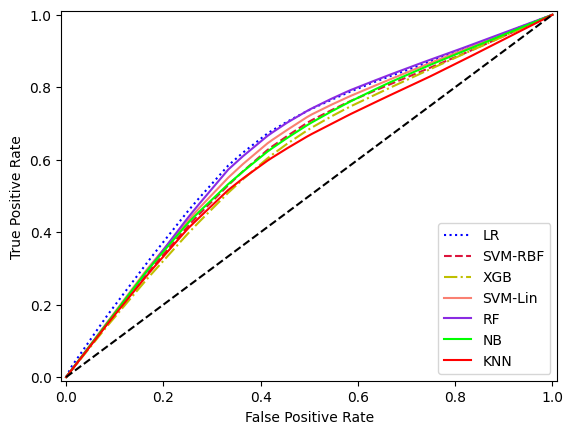

In [17]:
fixedResults_log = condenseResults(ResultsDict["LogReg"])
fixedResults_svmrbf = condenseResults(ResultsDict["SVMRBF"])
fixedResults_svmlin = condenseResults(ResultsDict["SVMLin"])
fixedResults_rf = condenseResults(ResultsDict["RF"])
fixedResults_xgb = condenseResults(ResultsDict["XGBoost"])
fixedResults_knn = condenseResults(ResultsDict["KNN"])
fixedResults_nb = condenseResults(ResultsDict["NB"])

base_fprs =np.linspace(0, 1, 100)

mean_tpr_log = np.mean(fixedResults_log["TPR"], axis=0)
mean_tpr_svmrbf = np.mean(fixedResults_svmrbf["TPR"], axis=0)
mean_tpr_svmlin = np.mean(fixedResults_svmlin["TPR"], axis=0)
mean_tpr_rf = np.mean(fixedResults_rf["TPR"], axis=0)
mean_tpr_xgb = np.mean(fixedResults_xgb["TPR"], axis=0)
mean_tpr_knn = np.mean(fixedResults_knn["TPR"], axis=0)
mean_tpr_nb = np.mean(fixedResults_nb["TPR"], axis=0)

#mean_tpr
plt.plot(base_fprs, mean_tpr_log, ls=':', color='b', label='LR')
plt.plot(base_fprs, mean_tpr_svmrbf,ls='--', color='crimson', label='SVM-RBF')
plt.plot(base_fprs, mean_tpr_xgb, ls='-.', color='y', label='XGB')
plt.plot(base_fprs, mean_tpr_svmlin, color='salmon', label='SVM-Lin')
plt.plot(base_fprs, mean_tpr_rf, color='blueviolet', label='RF')
plt.plot(base_fprs, mean_tpr_nb, color='lime', label='NB')
plt.plot(base_fprs, mean_tpr_knn, color='red', label='KNN')

plt.plot([0, 1], [0, 1],ls='--', color='black')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])


plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('../Images/20240108_ROCs_Nulliparous_BayesImpute.png', dpi=400, bbox_inches="tight")

# 5 - Feature Analysis

In [18]:
feature_display_names = {
    'wt': 'Weight',
    'weightDelivery': 'Weight at Delivery',
    'weightChange': 'Weight Change',
    'ht': 'Height',
    'age': 'Age',
    'gestage_delivery': 'Gest. age at delivery',
    'on_med': 'On Medication (Hypertension)',
    'cervex_dialation': 'Cervix Dilation',
    'oxy_augumtn': 'Oxy Augmentation',
    'oxy_maxdose': 'Oxy Max Dose',
    'race_1.0': 'White',
    'race_2.0': 'Black',
    'race_3.0': 'Hispanic',
    'race_4.0': 'Asian American',
    'race_5.0': 'Native American',
    'race_7.0': 'Unknown Race',
    'payor_status_1.0': 'Insurance (Self Pay)',
    'payor_status_2.0': 'Insurance (Government)',
    'payor_status_3.0': 'Insurance (Commercial)',
    'gbs_status_1.0': 'GBS Status (Positive)',
    'gbs_status_2.0': 'GBS Status (Negative)',
    'gbs_status_3.0': 'GBS Status (Unknown)',
    'cervex_station': 'Cervix Station',
    'cervex_efface': 'Cervix Efface',
    'AntepartumHospAdmissions': 'Antepartum Hosp. Admission',
    'neo_gen': 'Neonatal Gender',
    'Preeclampsia_Status': 'Preeclampsia Status',
    'neo_gen_1.0':"Neonatal Gender (Female)",
    'neo_gen_2.0':  "Neonatal Gender (Male)",
    #'mode_del': 'Cesarean',
    'spcy_ripen_1.0': 'Ripening (Misoprostol)',
    'spcy_ripen_2.0': 'Ripening (Foley bulb)',
    'spcy_ripen_3.0': 'Ripening (Miso and foley)',
    'spcy_ripen_4.0': 'Ripening (Cervidil)',
    'spcy_ripen_5.0': 'Ripening (Other)',
    'Diabetes_Diabetes (A1)': 'Diabetes (A1)',
    'Diabetes_Diabetes (A2)': 'Diabetes (A2)',
    'Diabetes_Diabetes (Type 1)': 'Diabetes (Type 1)',
    'Diabetes_Diabetes (Type 2)': 'Diabetes (Type 2)',
    "chro_hyper":"Chronic Hypertension",
    "gest_hyper": "Gestational Hypertension",
    "preeclampsia": "Preeclampsia",
    "preec_severe": "Preeclampsia (Severe)" 
    # Add more mappings as needed
}

X_train_shap = X_train.rename(columns=feature_display_names)
X_test_shap = X_test.rename(columns=feature_display_names)

In [19]:
X_train_shap.columns

Index(['Weight', 'Height', 'Age', 'On Medication (Hypertension)',
       'Gest. age at delivery', 'Cervix Dilation', 'Cervix Efface',
       'Cervix Station', 'Oxy Augmentation', 'Oxy Max Dose', 'Neonatal Gender',
       'Diabetes', 'Preeclampsia Status', 'Antepartum Hosp. Admission',
       'Hypertension', 'Weight Change', 'White', 'Black', 'Hispanic',
       'Asian American', 'Native American', 'Unknown Race',
       'Insurance (Self Pay)', 'Insurance (Government)',
       'Insurance (Commercial)', 'GBS Status (Positive)',
       'GBS Status (Negative)', 'GBS Status (Unknown)'],
      dtype='object')

## 5.1 - SHAP

### Nulliparous Data

In [20]:
X_train_shap.columns

Index(['Weight', 'Height', 'Age', 'On Medication (Hypertension)',
       'Gest. age at delivery', 'Cervix Dilation', 'Cervix Efface',
       'Cervix Station', 'Oxy Augmentation', 'Oxy Max Dose', 'Neonatal Gender',
       'Diabetes', 'Preeclampsia Status', 'Antepartum Hosp. Admission',
       'Hypertension', 'Weight Change', 'White', 'Black', 'Hispanic',
       'Asian American', 'Native American', 'Unknown Race',
       'Insurance (Self Pay)', 'Insurance (Government)',
       'Insurance (Commercial)', 'GBS Status (Positive)',
       'GBS Status (Negative)', 'GBS Status (Unknown)'],
      dtype='object')

In [21]:
#background = shap.maskers.Independent(X, max_samples=1000)
explainer_svm = shap.KernelExplainer(rf.predict, X_train_shap)
shap_values_svm = explainer_svm(X_train_shap)

Using 239 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/239 [00:00<?, ?it/s]

In [30]:
plt.gcf()
plt.close("all")
shap.plots.waterfall(shap_values_svm[0],max_display=20, show=False)
plt.savefig('../Images/20240108_Negative_SHAP_Nulliparous.png', dpi=400, bbox_inches="tight")

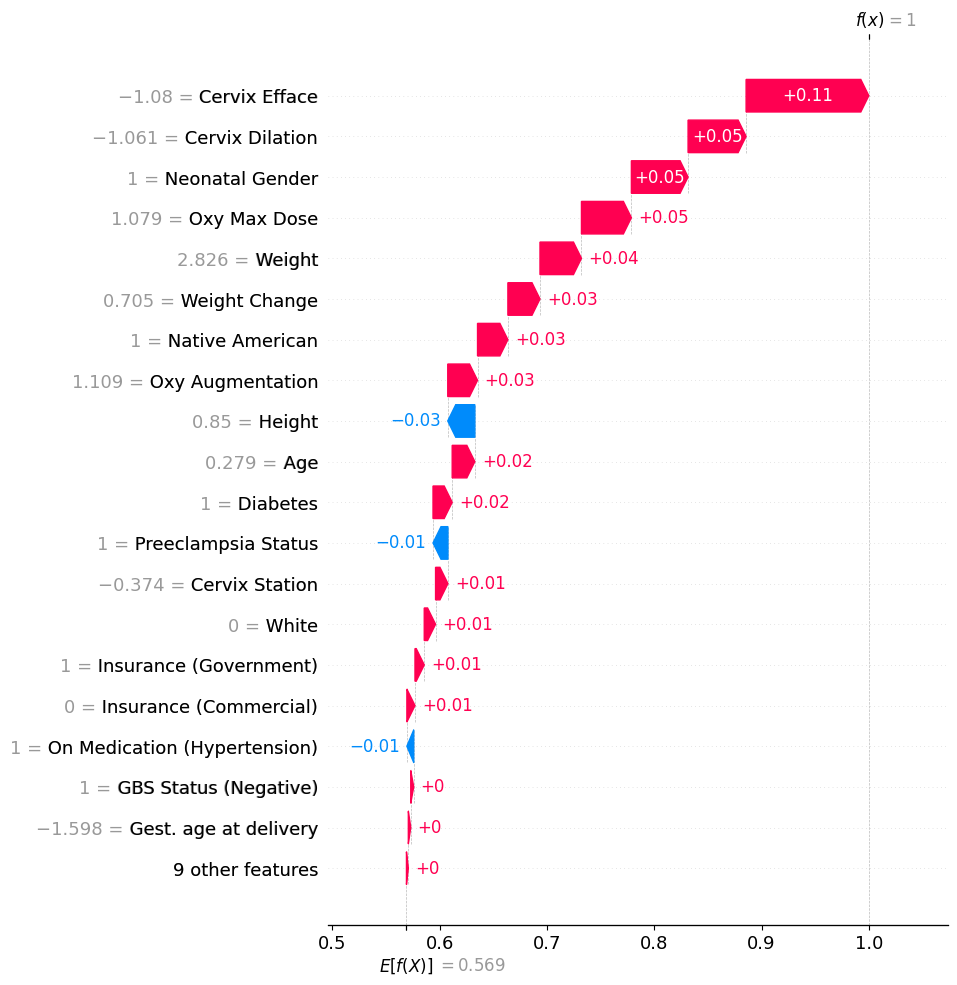

In [29]:
plt.gcf()
plt.close("all")
shap.plots.waterfall(shap_values_svm[1],max_display=20, show=True)
#plt.savefig('../Images/20240108_Positive_SHAP_Nulliparous.png', dpi=400, bbox_inches="tight")

In [31]:
plt.gcf()
plt.close("all")
shap.summary_plot(shap_values_svm, X_train_shap, show=False)
plt.savefig('../Images/20240108_Swarmplot_SHAP_Nulliparous.png', dpi=400, bbox_inches="tight")

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!


### Multiparous

In [8]:
X_train_shap.shape

(820, 41)

In [59]:
df.shape

(920, 25)

In [22]:
rf

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=1600)

In [9]:
#background = shap.maskers.Independent(X, max_samples=1000)
explainer_svm = shap.KernelExplainer(rf.predict, X_train_shap)
shap_values_svm = explainer_svm(X_train_shap)

Using 820 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/820 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.gcf()
plt.close("all")
shap.summary_plot(shap_values_svm, X_train_shap, show=True)

## 5.2 - Odds Ratios

In [32]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=36851234)
xYDict = {}
counter = 1

X,y = prepData(df)

# Initialize an array to store coefficients from each fold
X_train, _, _ = encodeData(X, X, X, encodeCols, PARAMS) # To figure out how many I'm getting
#X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
# Dictionary to store coefficient values for each feature
coefficients_dict = {}

# Counter for the fold
counter = 1

In [33]:
X_train.columns

Index(['wt', 'ht', 'age', 'on_med', 'gestage_delivery', 'cervex_dialation',
       'cervex_efface', 'cervex_station', 'oxy_augumtn', 'oxy_maxdose',
       'neo_gen', 'Diabetes', 'Preeclampsia_Status',
       'AntepartumHospAdmissions', 'Hypertension', 'weightChange', 'race_1.0',
       'race_2.0', 'race_3.0', 'race_4.0', 'race_5.0', 'race_7.0',
       'payor_status_1.0', 'payor_status_2.0', 'payor_status_3.0',
       'gbs_status_1.0', 'gbs_status_2.0', 'gbs_status_3.0'],
      dtype='object')

In [34]:
for train_index, test_index in rskf.split(X, y):
    #print(counter)

    # Split Data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Prep Data --------------------------------------------------------------------------
    X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
    X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
    X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
    X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
    X_train, y_train = detectOutliers(X_train, y_train, PARAMS)

    print(X_train.shape[1])

    X_train.rename(columns=feature_display_names, inplace=True)
    X_test.rename(columns=feature_display_names, inplace=True)
    
    #X_train.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)
    #X_test.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)

    #X_train.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)
    #X_test.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)



    # Create and train the logistic regression model for each fold
    model = LogisticRegression()
    model.fit(X_train, y_train.ravel())

    # Store the coefficients for each feature
    for feature_index, feature_name in enumerate(X_train.columns):
        if feature_name not in coefficients_dict:
            coefficients_dict[feature_name] = []
        coefficients_dict[feature_name].append(model.coef_[0][feature_index])

    counter += 1

# Calculate the average coefficients
average_coefficients = {feature_name: np.mean(coef_list) for feature_name, coef_list in coefficients_dict.items()}

# Create a DataFrame to store the results
result_df = pd.DataFrame({'Feature': list(average_coefficients.keys()), 'Average Coefficient': list(average_coefficients.values())})

# Print the average coefficients for each feature
for feature_name, avg_coef in average_coefficients.items():
    print(f'Feature: {feature_name}, Average Coefficient: {avg_coef}')

result_df["Log Odds"] = np.exp(result_df["Average Coefficient"])
df_sorted = result_df.sort_values(by='Log Odds', ascending=False)

[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28


[IterativeImputer] Early stopping criterion not reached.


28
28
Feature: Weight, Average Coefficient: 0.4582613067767874
Feature: Height, Average Coefficient: -0.44989447088132467
Feature: Age, Average Coefficient: 0.6566395040473023
Feature: On Medication (Hypertension), Average Coefficient: -0.1170857771529278
Feature: Gest. age at delivery, Average Coefficient: 0.023604809838092117
Feature: Cervix Dilation, Average Coefficient: -0.031835861685261084
Feature: Cervix Efface, Average Coefficient: -0.7009997744724168
Feature: Cervix Station, Average Coefficient: -0.1854395438538873
Feature: Oxy Augmentation, Average Coefficient: -0.0608773338653011
Feature: Oxy Max Dose, Average Coefficient: 0.11764271966394761
Feature: Neonatal Gender, Average Coefficient: 0.7777525640706261
Feature: Diabetes, Average Coefficient: 0.6081525024742931
Feature: Preeclampsia Status, Average Coefficient: -0.8581797795864418
Feature: Antepartum Hosp. Admission, Average Coefficient: 0.14305140034218494
Feature: Hypertension, Average Coefficient: -0.5693193902097385


[IterativeImputer] Early stopping criterion not reached.


In [35]:
df_sorted

,Feature,Average Coefficient,Log Odds
10,Neonatal Gender,0.777753,2.176575
20,Native American,0.664031,1.942608
2,Age,0.656640,1.928301
11,Diabetes,0.608153,1.837034
15,Weight Change,0.531556,1.701577
0,Weight,0.458261,1.581322
26,GBS Status (Negative),0.321377,1.379025
23,Insurance (Government),0.300596,1.350664
24,Insurance (Commercial),0.205771,1.228471
18,Hispanic,0.170624,1.186044


In [38]:
X_train.columns

Index(['Weight', 'Height', 'Age', 'On Medication (Hypertension)',
       'Gest. age at delivery', 'Cervix Dilation', 'Cervix Efface',
       'Cervix Station', 'Oxy Augmentation', 'Neonatal Gender', 'Diabetes',
       'Preeclampsia Status', 'Antepartum Hosp. Admission', 'Hypertension',
       'Weight Change', 'White', 'Black', 'Hispanic', 'Asian American',
       'Native American', 'Unknown Race', 'Insurance (Self Pay)',
       'Insurance (Government)', 'GBS Status (Positive)',
       'GBS Status (Unknown)'],
      dtype='object')

In [39]:
X.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'on_med', 'gbs_status',
       'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'Diabetes',
       'Preeclampsia_Status', 'AntepartumHospAdmissions', 'Hypertension',
       'weightDelivery', 'weightChange'],
      dtype='object')

## 5.3 - Random Forest Feature Ranking

In [15]:
X.columns

Index(['wt', 'ht', 'age', 'race', 'payor_status', 'use_ripen', 'on_med',
       'gbs_status', 'gestage_delivery', 'cervex_dialation', 'cervex_efface',
       'cervex_station', 'oxy_augumtn', 'oxy_maxdose', 'neo_gen', 'Diabetes',
       'Preeclampsia_Status', 'AntepartumHospAdmissions', 'Hypertension',
       'weightChange'],
      dtype='object')

In [6]:
feature_display_names = {
    'wt': 'Weight at First Visit',
    'weightDelivery': 'Weight at Delivery',
    'weightChange': 'Weight Change',
    'ht': 'Height',
    'age': 'Age',
    'gestage_delivery': 'Gest. age at delivery',
    'on_med': 'On Medication (Hypertension)',
    'cervex_dialation': 'Cervix Dilation',
    'oxy_augumtn': 'Oxy Augmentation',
    'oxy_maxdose': 'Oxy Max Dose',
    'race_1.0': 'White',
    'race_2.0': 'Black',
    'race_3.0': 'Hispanic',
    'race_4.0': 'Asian American',
    'race_5.0': 'Native American',
    'race_7.0': 'Unknown Race',
    'payor_status_1.0': 'Insurance (Self Pay)',
    'payor_status_2.0': 'Insurance (Government)',
    'payor_status_3.0': 'Insurance (Commercial)',
    'gbs_status_1.0': 'GBS Status (Positive)',
    'gbs_status_2.0': 'GBS Status (Negative)',
    'gbs_status_3.0': 'GBS Status (Unknown)',
    'cervex_station': 'Cervix Station',
    'cervex_efface': 'Cervix Efface',
    'AntepartumHospAdmissions': 'Antepartum Hosp. Admission',
    'neo_gen': 'Neonatal Gender',
    'Preeclampsia_Status': 'Preeclampsia Status',
    'neo_gen_1.0':"Neonatal Gender (Female)",
    'neo_gen_2.0':  "Neonatal Gender (Male)",
    #'mode_del': 'Cesarean',
    'spcy_ripen_1.0': 'Ripening (Misoprostol)',
    'spcy_ripen_2.0': 'Ripening (Foley bulb)',
    'spcy_ripen_3.0': 'Ripening (Miso and foley)',
    'spcy_ripen_4.0': 'Ripening (Cervidil)',
    'spcy_ripen_5.0': 'Ripening (Other)',
    'Diabetes_Diabetes (A1)': 'Diabetes (A1)',
    'Diabetes_Diabetes (A2)': 'Diabetes (A2)',
    'Diabetes_Diabetes (Type 1)': 'Diabetes (Type 1)',
    'Diabetes_Diabetes (Type 2)': 'Diabetes (Type 2)',
    "chro_hyper":"Chronic Hypertension",
    "gest_hyper": "Gestational Hypertension",
    "preeclampsia": "Preeclampsia",
    "preec_severe": "Preeclampsia (Severe)" 
    # Add more mappings as needed
}

X_train_shap = X_train.rename(columns=feature_display_names)
X_test_shap = X_test.rename(columns=feature_display_names)

NameError: name 'X_train' is not defined

In [38]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=36851234)
xYDict = {}
counter = 1

X,y = prepData(df)

# Initialize an array to store coefficients from each fold
X_train, _, _ = encodeData(X, X, X, encodeCols, PARAMS) # To figure out how many I'm getting

# Dictionary to store coefficient values for each feature
coefficients_dict = {}

# Counter for the fold
counter = 1

for train_index, test_index in rskf.split(X, y):
    #print(counter)

    # Split Data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Prep Data --------------------------------------------------------------------------
    X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
    X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
    X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
    #X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
    X_train, y_train = detectOutliers(X_train, y_train, PARAMS)

    X_train.rename(columns=feature_display_names, inplace=True)
    X_test.rename(columns=feature_display_names, inplace=True)
    X_train.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)
    X_test.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)

    X_train.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)
    X_test.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)

[IterativeImputer] Early stopping criterion not reached.


In [39]:
hyper = {'n_estimators': 1600,
                 'min_samples_split': 2,
                 'min_samples_leaf': 4,
                 'max_features': 'sqrt',
                 'max_depth': 10,
                 'bootstrap': True}

rf = RandomForestClassifier(n_estimators=hyper['n_estimators'],
                                                min_samples_split=hyper['min_samples_split'],
                                                min_samples_leaf=hyper['min_samples_leaf'],
                                                max_features=hyper['max_features'],
                                                max_depth=hyper['max_depth'],
                                                bootstrap=hyper['bootstrap'])
rf.fit(X_train, y_train.values)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=1600)

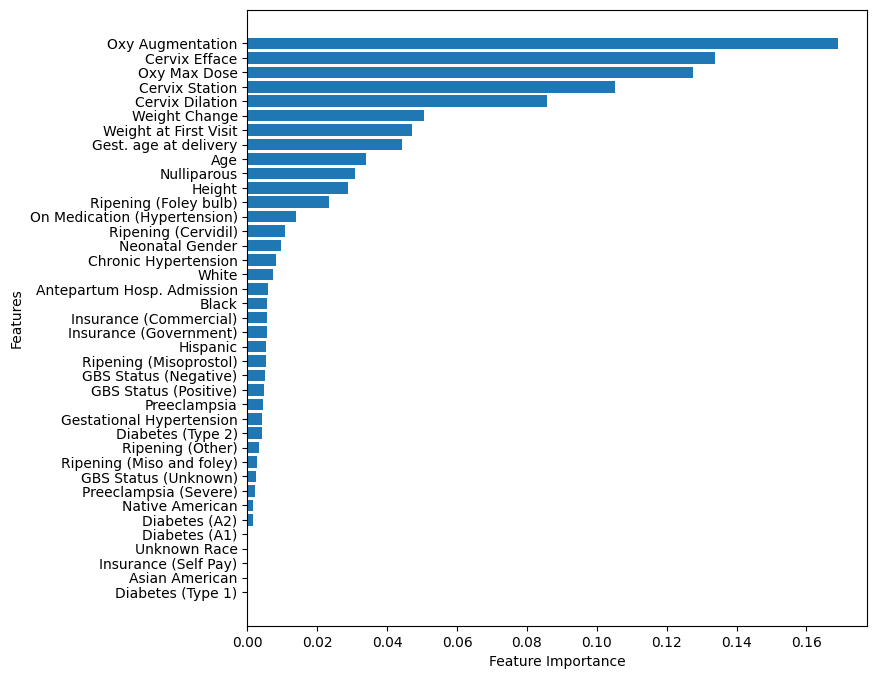

In [41]:
# Create a RandomForestClassifier
plt.figure(figsize=(8, 8))

# Get feature importances from the model
importances = rf.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort indices by importance
indices = importances.argsort()

# Plot horizontal bar chart
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
#plt.title('Random Forest Feature Importance')
plt.savefig('../Images/20240202_Multiparous_RandomForest_FeatureImportance.png', dpi=400, bbox_inches="tight")
plt.show()

## 5.4 - XGBoost Feature Ranking

In [29]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=36851234)
xYDict = {}
counter = 1

X,y = prepData(df)

# Initialize an array to store coefficients from each fold
X_train, _, _ = encodeData(X, X, X, encodeCols, PARAMS) # To figure out how many I'm getting

# Dictionary to store coefficient values for each feature
coefficients_dict = {}

# Counter for the fold
counter = 1

for train_index, test_index in rskf.split(X, y):
    #print(counter)

    # Split Data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Prep Data --------------------------------------------------------------------------
    X_train, X_test = normalizeData(X_train, X_test, scaleColumns, PARAMS)
    X_train, X_test, list_of_encoded = encodeData(X_train, X_test, X, encodeCols, PARAMS)
    X_train, X_test = imputeMissing(X_train, X_test, PARAMS, list_of_encoded)
    #X_train, X_test = remove_highly_correlated(X_train, X_test, PARAMS)
    X_train, y_train = detectOutliers(X_train, y_train, PARAMS)

    X_train.rename(columns=feature_display_names, inplace=True)
    X_test.rename(columns=feature_display_names, inplace=True)
    #X_train.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)
    #X_test.drop(labels=["Diabetes_No Diabetes"], axis=1, inplace=True)

    #X_train.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)
    #X_test.drop(labels=["spcy_ripen_0.0"], axis=1, inplace=True)

[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.
[IterativeImputer] Early stopping criterion not reached.


In [25]:
X_train.columns

Index(['Weight at First Visit', 'Height', 'Age', 'spcy_ripen',
       'On Medication (Hypertension)', 'Gest. age at delivery',
       'Cervix Dilation', 'Cervix Efface', 'Cervix Station',
       'Oxy Augmentation', 'Oxy Max Dose', 'Neonatal Gender', 'Diabetes',
       'Preeclampsia Status', 'Antepartum Hosp. Admission', 'Hypertension',
       'Weight Change', 'White', 'Black', 'Hispanic', 'Asian American',
       'Native American', 'Unknown Race', 'Insurance (Self Pay)',
       'Insurance (Government)', 'Insurance (Commercial)',
       'GBS Status (Positive)', 'GBS Status (Negative)',
       'GBS Status (Unknown)'],
      dtype='object')

In [278]:
feature_display_names = {
    'wt': 'Weight',
    'weightChange': 'Weight Change',
    'ht': 'Height',
    'age': 'Age',
    'gestage_delivery': 'Gest. age at delivery',
    'on_med': 'On Medication (Hypertension)',
    'cervex_dialation': 'Cervix Dilation',
    'oxy_augumtn': 'Oxy Augmentation',
    'oxy_maxdose': 'Oxy Max Dose',
    'race_1.0': 'White',
    'race_2.0': 'Black',
    'race_3.0': 'Hispanic',
    'race_4.0': 'Asian American',
    'race_5.0': 'Native American',
    'race_7.0': 'Unknown Race',
    'payor_status_1.0': 'Insurance (Self Pay)',
    'payor_status_2.0': 'Insurance (Government)',
    'payor_status_3.0': 'Insurance (Commercial)',
    'gbs_status_1.0': 'GBS Status (Positive)',
    'gbs_status_2.0': 'GBS Status (Negative)',
    'gbs_status_3.0': 'GBS Status (Unknown)',
    'cervex_station': 'Cervix Station',
    'cervex_efface': 'Cervix Efface',
    'AntepartumHospAdmissions': 'Antepartum Hosp. Admission',
    'neo_gen': 'Neonatal Gender',
    'Preeclampsia_Status': 'Preeclampsia Status',
    'neo_gen':"Neonatal Gender (Female)",
    'mode_del': 'Cesarean',
    'spcy_ripen_1.0': 'Ripening (Misoprostol)',
    'spcy_ripen_2.0': 'Ripening (Foley bulb)',
    'spcy_ripen_3.0': 'Ripening (Miso and foley)',
    'spcy_ripen_4.0': 'Ripening (Cervidil)',
    'spcy_ripen_5.0': 'Ripening (Other)',
    'Diabetes_Diabetes (A1)': 'Diabetes (A1)',
    'Diabetes_Diabetes (A2)': 'Diabetes (A2)',
    'Diabetes_Diabetes (Type 1)': 'Diabetes (Type 1)',
    'Diabetes_Diabetes (Type 2)': 'Diabetes (Type 2)',
    "chro_hyper":"Chronic Hypertension",
    "gest_hyper": "Gestational Hypertension",
    "preeclampsia": "Preeclampsia",
    "preec_severe": "Preeclampsia (Severe)" 
    # Add more mappings as needed
}

X_train = X_train.rename(columns=feature_display_names)

In [279]:
X_train.columns

Index(['Weight', 'Height', 'Age', 'On Medication (Hypertension)',
       'Gest. age at delivery', 'Cervix Dilation', 'Cervix Efface',
       'Cervix Station', 'Oxy Augmentation', 'Oxy Max Dose', 'Neonatal Gender',
       'Diabetes', 'Preeclampsia Status', 'Antepartum Hosp. Admission',
       'Hypertension', 'Weight Change', 'White', 'Black', 'Hispanic',
       'Asian American', 'Native American', 'Unknown Race',
       'Insurance (Self Pay)', 'Insurance (Government)',
       'Insurance (Commercial)', 'GBS Status (Positive)',
       'GBS Status (Negative)', 'GBS Status (Unknown)'],
      dtype='object')

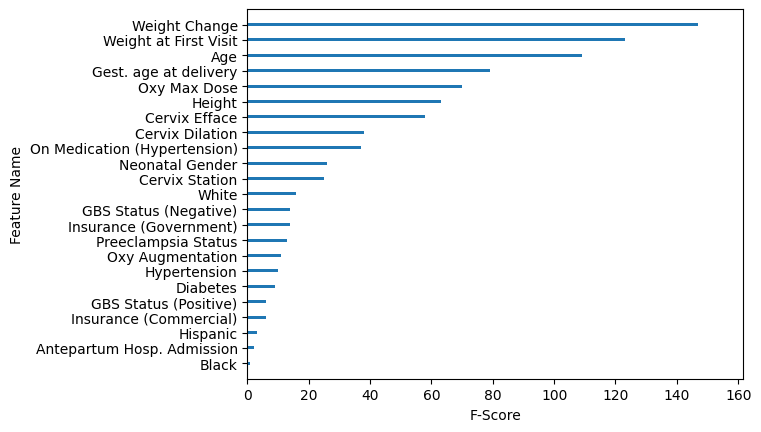

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)

# Save graph
ax = plot_importance(model, max_num_features=X.shape[0], grid=False, show_values=False)
fig1 = pyplot.gcf()

plt.xlabel('F-Score')
plt.ylabel('Feature Name')
plt.title('')
# pyplot.show()

fig1.savefig('../Images/20240213_XGBoostTopFeatures_nulliparous.png', bbox_inches='tight')

# Old Code

## Manual Recording

In [86]:
logRegResults = condenseResults(ResultsDict["LogReg"])
svmResults = condenseResults(ResultsDict["SVM"])
xgbResults = condenseResults(ResultsDict["XGB"])
rfResults = condenseResults(ResultsDict["RF"])
svmLinResults = condenseResults(ResultsDict["SVMLin"])
knnResults = condenseResults(ResultsDict["KNN"])
nbResults = condenseResults(ResultsDict["NB"])

meanLR = meanResults(logRegResults)
meanSVM = meanResults(svmResults)
meanXGB = meanResults(xgbResults)
meanRF = meanResults(rfResults)
meanSVMLin = meanResults(svmLinResults)
meanKNN = meanResults(knnResults)
meanNB = meanResults(nbResults)

data = [['LogReg', meanLR['Accuracy'], meanLR['AUC'],meanLR['Gmean'],meanLR['Recall'],meanLR['Precision'],meanLR['Specificity']], 
        ['SVM', meanSVM['Accuracy'], meanSVM['AUC'],meanSVM['Gmean'],meanSVM['Recall'],meanSVM['Precision'],meanSVM['Specificity']],
       ['XGB', meanXGB['Accuracy'], meanXGB['AUC'],meanXGB['Gmean'],meanXGB['Recall'],meanXGB['Precision'],meanXGB['Specificity']],
       ['RF', meanRF['Accuracy'], meanRF['AUC'],meanRF['Gmean'],meanRF['Recall'],meanRF['Precision'],meanRF['Specificity']], 
       ['SVMLin', meanSVMLin['Accuracy'], meanSVMLin['AUC'],meanSVMLin['Gmean'],meanSVMLin['Recall'],meanSVMLin['Precision'],meanSVMLin['Specificity']],
       ['NB', meanNB['Accuracy'], meanNB['AUC'],meanNB['Gmean'],meanNB['Recall'],meanNB['Precision'],meanNB['Specificity']],
       ['KNN', meanKNN['Accuracy'], meanKNN['AUC'],meanKNN['Gmean'],meanKNN['Recall'],meanKNN['Precision'],meanKNN['Specificity']]]

# Create the pandas DataFrame 
Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 

# Create the pandas DataFrame 
Diabetes_Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 


KeyError: 'SVM'

In [68]:
#logRegResults = condenseResults(ResultsDict["LogReg"])
#svmResults = condenseResults(ResultsDict["SVM"])
#xgbResults = condenseResults(ResultsDict["XGB"])
#rfResults = condenseResults(ResultsDict["RF"])
#svmLinResults = condenseResults(ResultsDict["SVMLin"])
knnResults = condenseResults(ResultsDict["KNN"])
nbResults = condenseResults(ResultsDict["NB"])

#meanLR = meanResults(logRegResults)
#meanSVM = meanResults(svmResults)
#meanXGB = meanResults(xgbResults)
#meanRF = meanResults(rfResults)
#meanSVMLin = meanResults(svmLinResults)
meanKNN = meanResults(knnResults)
meanNB = meanResults(nbResults)

data = [#['LogReg', meanLR['Accuracy'], meanLR['AUC'],meanLR['Gmean'],meanLR['Recall'],meanLR['Precision'],meanLR['Specificity']], 
        #['SVM', meanSVM['Accuracy'], meanSVM['AUC'],meanSVM['Gmean'],meanSVM['Recall'],meanSVM['Precision'],meanSVM['Specificity']],
       #['XGB', meanXGB['Accuracy'], meanXGB['AUC'],meanXGB['Gmean'],meanXGB['Recall'],meanXGB['Precision'],meanXGB['Specificity']],
       #['RF', meanRF['Accuracy'], meanRF['AUC'],meanRF['Gmean'],meanRF['Recall'],meanRF['Precision'],meanRF['Specificity']], 
       #['SVMLin', meanSVMLin['Accuracy'], meanSVMLin['AUC'],meanSVMLin['Gmean'],meanSVMLin['Recall'],meanSVMLin['Precision'],meanSVMLin['Specificity']],
       ['NB', meanNB['Accuracy'], meanNB['AUC'],meanNB['Gmean'],meanNB['Recall'],meanNB['Precision'],meanNB['Specificity']],
       ['KNN', meanKNN['Accuracy'], meanKNN['AUC'],meanKNN['Gmean'],meanKNN['Recall'],meanKNN['Precision'],meanKNN['Specificity']]]

# Create the pandas DataFrame 
Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 

## 4.1 - Uncollapsed Diabetes Results

In [13]:
logRegResults = condenseResults(ResultsDict["LogReg"])
svmResults = condenseResults(ResultsDict["SVM"])
xgbResults = condenseResults(ResultsDict["XGB"])
rfResults = condenseResults(ResultsDict["RF"])
svmLinResults = condenseResults(ResultsDict["SVMLin"])

meanLR = meanResults(logRegResults)
meanSVM = meanResults(svmResults)
meanXGB = meanResults(xgbResults)
meanRF = meanResults(rfResults)
meanSVMLin = meanResults(svmLinResults)

data = [['LogReg', meanLR['Accuracy'], meanLR['AUC'],meanLR['Gmean'],meanLR['Recall'],meanLR['Precision'],meanLR['Specificity']], 
        ['SVM', meanSVM['Accuracy'], meanSVM['AUC'],meanSVM['Gmean'],meanSVM['Recall'],meanSVM['Precision'],meanSVM['Specificity']],
       ['XGB', meanXGB['Accuracy'], meanXGB['AUC'],meanXGB['Gmean'],meanXGB['Recall'],meanXGB['Precision'],meanXGB['Specificity']],
       ['RF', meanRF['Accuracy'], meanRF['AUC'],meanRF['Gmean'],meanRF['Recall'],meanRF['Precision'],meanRF['Specificity']], 
       ['SVMLin', meanSVMLin['Accuracy'], meanSVMLin['AUC'],meanSVMLin['Gmean'],meanSVMLin['Recall'],meanSVMLin['Precision'],meanSVMLin['Specificity']]]

# Create the pandas DataFrame 
Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 

# Create the pandas DataFrame 
Diabetes_Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 
Diabetes_Results

,Model,Accuracy,AUC,Gmean,Recall,Precision,Specificity
0,SVMLin,0.638904,0.529162,0.186076,0.229673,0.21686,0.82865


Gmeans: 
* alpha 0.01 = 0.155
* alpha 0.1 = 0.10
* alpha 1 = 0.095

## 4.2 - Uncollapsed Hypertension Results

In [174]:
logRegResults = condenseResults(ResultsDict["LogReg"])
svmResults = condenseResults(ResultsDict["SVM"])

meanLR = meanResults(logRegResults)
meanSVM = meanResults(svmResults)

data = [['LogReg', meanLR['Accuracy'], meanLR['AUC'],meanLR['Gmean'],meanLR['Recall'],meanLR['Precision'],meanLR['Specificity']], 
        ['SVM', meanSVM['Accuracy'], meanSVM['AUC'],meanSVM['Gmean'],meanSVM['Recall'],meanSVM['Precision'],meanSVM['Specificity']]]

# Create the pandas DataFrame 
Hypertension_Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 
Hypertension_Results

KeyError: 'LogReg'

## 4.3 - Remove Weight Change and keep Hypertension uncollapsed, Keep BMI

In [126]:
logRegResults = condenseResults(ResultsDict["LogReg"])
svmResults = condenseResults(ResultsDict["SVM"])

meanLR = meanResults(logRegResults)
meanSVM = meanResults(svmResults)

data = [['LogReg', meanLR['Accuracy'], meanLR['AUC'],meanLR['Gmean'],meanLR['Recall'],meanLR['Precision'],meanLR['Specificity']], 
        ['SVM', meanSVM['Accuracy'], meanSVM['AUC'],meanSVM['Gmean'],meanSVM['Recall'],meanSVM['Precision'],meanSVM['Specificity']]]

# Create the pandas DataFrame 
Weight_Results = pd.DataFrame(data, columns=['Model', 'Accuracy', 'AUC', 'Gmean', 'Recall', 'Precision', 'Specificity']) 
Weight_Results

,Model,Accuracy,AUC,Gmean,Recall,Precision,Specificity
0,LogReg,0.673874,0.674364,0.667051,0.670000,0.692392,0.678727
1,SVM,0.596482,0.606833,0.522888,0.312576,0.788738,0.901091


## 4.4 - Uncollapse Diabetes and Hypertension at the same time

# 5 - Feature Analysis

In [ ]:
encodeCols = ["race", "payor_status", "gbs_status", "neo_gen"]
df = encodeData(df, encodeCols, PARAMS)

feature_display_names = {
    'wt': 'Weight',
    'weightDelivery': 'Weight at Delivery',
    'weightChange': 'Weight Change',
    'ht': 'Height',
    'age': 'Age',
    'gestage_delivery': 'Gest. age at delivery',
    'on_med': 'On Medication (Hypertension)',
    'cervex_dialation': 'Cervix Dilation',
    'oxy_augumtn': 'Oxy Augmentation',
    'oxy_maxdose': 'Oxy Max Dose',
    'race_1.0': 'White',
    'race_2.0': 'Black',
    'race_3.0': 'Hispanic',
    'race_4.0': 'Asian American',
    'race_5.0': 'Native American',
    'race_7.0': 'Unknown Race',
    'payor_status_1.0': 'Insurance (Self Pay)',
    'payor_status_2.0': 'Insurance (Government)',
    'payor_status_3.0': 'Insurance (Commercial)',
    'gbs_status_1.0': 'GBS Status (Positive)',
    'gbs_status_2.0': 'GBS Status (Negative)',
    'gbs_status_3.0': 'GBS Status (Unknown)',
    'cervex_station': 'Cervix Station',
    'cervex_efface': 'Cervix Efface',
    'AntepartumHospAdmissions': 'Antepartum Hosp. Admission',
    'neo_gen': 'Neonatal Gender',
    'Preeclampsia_Status': 'Preeclampsia Status',
    'neo_gen_Female': "Neonatal Gender (Female)",
    'neo_gen_Male': "Neonatal Gender (Male)",
    'mode_del': 'Cesarean'
    # Add more mappings as needed
}

data.rename(columns=feature_display_names, inplace=True)